## WEEK 6

#### 1.
Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте Q 
may — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

In [1]:
import utils
import gc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from types import SimpleNamespace
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from scipy.stats import ttest_1samp
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, MiniBatchKMeans

In [2]:
%%time
# Выгрузим данные по зонам из числа отобранных на второй неделе, то есть те, у которых в мае 2016 года было больше 5 поездок в час
aws = utils.AWSUtils()
data = aws.pd_read_sql(
    sql="\
    SELECT \
        dt.trip_datetime, \
        r.region_id, \
        COALESCE(ad.trip_count_sum, 0) trip_count_sum, \
        COALESCE(ad.passenger_count_mean, 0) passenger_count_mean, \
        COALESCE(ad.trip_distance_mean, 0) trip_distance_mean, \
        COALESCE(ad.total_amount_mean, 0) total_amount_mean, \
        COALESCE(ad.trip_duration_mean, 0) trip_duration_mean \
    \
    FROM \
        mldb.taxi_tripdt dt \
        CROSS JOIN taxi_regions r \
        LEFT JOIN mldb.taxi_aggregateddata ad ON ad.pickup_datetime=dt.trip_datetime and ad.pickup_region_id=r.region_id \
        INNER JOIN \
            (SELECT \
                pickup_region_id, \
                sum(trip_count_sum)/24/31 trip_avg_ph \
            FROM \
                 mldb.taxi_aggregateddata \
            WHERE \
                MONTH(pickup_datetime) = 5 \
                AND YEAR(pickup_datetime) = 2016 \
            GROUP BY \
                pickup_region_id \
            HAVING \
                trip_avg_ph >= 5 \
            ) adf ON adf.pickup_region_id = r.region_id \
    WHERE \
        dt.trip_datetime BETWEEN '{min_dt}' AND '{max_dt}';"
    .format(
        min_dt='2014-05-01 00:00:00',
        max_dt='2016-06-30 23:00:00'
    ),
    index_col='trip_datetime',
    parse_dates={'trip_datetime': {'format': '%Y-%m-%d %H:%M:%S'}}
)

CPU times: user 49 s, sys: 2.01 s, total: 51 s
Wall time: 1min 39s


In [3]:
# посмотрим на данные, что все выгрузилось корректно
data.tail()

region_id  trip_count_sum  passenger_count_mean  \
trip_datetime                                                          
2016-06-30 23:00:00       1390              15              1.733333   
2016-06-30 23:00:00       1439               9              1.888889   
2016-06-30 23:00:00       1441               2              1.000000   
2016-06-30 23:00:00       1442               5              1.200000   
2016-06-30 23:00:00       1783             110              1.518182   

                     trip_distance_mean  total_amount_mean  trip_duration_mean  
trip_datetime                                                                   
2016-06-30 23:00:00            3.086667          15.818666           12.031111  
2016-06-30 23:00:00            1.665556           9.910000            6.161111  
2016-06-30 23:00:00            9.350000          34.549999           36.025002  
2016-06-30 23:00:00            1.722000          10.648000            8.266666  
2016-06-30 23:00:00            9.910182          47.711636           43.905605

In [4]:
# класс-сплитер исходных данных на выборки
class TripData():
    def __init__(self, data, *additional_transformers):
        self.date_index = data.index.unique()
        self._additional_transformers = additional_transformers
        self.data = (
            data.reset_index()
            .sort_values(['trip_datetime', 'region_id'])
            .set_index('trip_datetime')
        )
        self._fit_X_y()
    
    def _fit_X_y(self):
        
        self.train_idx = np.where(self.data.index.isin(self.data.loc[:'2016-04-30 17:00:00'].index))[0]
        self.test_idx = np.where(self.data.index.isin(self.data.loc['2016-04-30 23:00:00':'2016-05-31 17:00:00'].index))[0]
        self.final_idx = np.where(self.data.index.isin(self.data.loc['2016-05-31 23:00:00':'2016-06-30 17:00:00'].index))[0]

        self._X = TaxiTripTransformer(self.date_index, *self._additional_transformers).fit_transform(self.data)
    
    def _shift_y(self, data, T):
        region_count = data.region_id.unique().shape[0]
        return data.shift(-T*region_count).fillna(0).trip_count_sum
    
    def unsplit(self, T):
        return SimpleNamespace(
            X=self._X,
            y=self._shift_y(self.data, T)
        )
    
    def train(self, T):
        X=self._X[np.where(self.data.index.isin(self.data.loc[:'2016-05-31 17:00:00'].index))[0]]
        y=self._shift_y(
                self.data.loc[:'2016-05-31 23:00:00'],
                T
            ).iloc[: X.shape[0]]
        
        return SimpleNamespace(
            X=X,
            y=y
        )
    
    def test(self, T):
        X = self._X[self.final_idx]
        y = self._shift_y(
            self.data.loc['2016-06-01 00:00:00':'2016-06-30 23:00:00'],
            T
        ).iloc[: X.shape[0]]
        
        return SimpleNamespace(
            X=X,
            y=y
        )
    
    def cv(self):
        yield (
            self.train_idx,
            self.test_idx
        )

# генератор новых признаков
class TaxiTripTransformer(TransformerMixin):
    def __init__(self, series_index, *additional_transformers):
        self.series_index = series_index
        self._additional_transformers = additional_transformers

    def _fourier_harmonic(self, X, series_index, k_values, period):
        values = np.array([series_index.get_loc(n) for n in X.index.values])
        
        return csr_matrix(
            np.array([
                func(values*2*math.pi*k/period) for k in k_values for func in (np.sin, np.cos)
            ]).T
        )
    
    def _shift_defauls(self, X):
        df = X.copy()
        df.loc[:, 'hour'] = df.index.hour
        
        return (
            df.pivot_table(
                values='trip_count_sum', 
                index='hour',
                columns='region_id',
                fill_value=0
            )
            .groupby(['hour'])
            .mean()
        )
    
    def _shift_function(self, X, range_func):
        df_defauls = self._shift_defauls(X)
        
        X_pivot = X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )

        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(
                    X_pivot
                    .head(hour)
                    .apply(
                        lambda x: df_defauls.loc[(x.name-pd.Timedelta(hours=hour)).hour], 
                        axis=1
                    )
                )
                .stack()
                for hour in range_func
            ]).T
        )

    def _sum_function(self, X, periods):
        X_pivot = X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )

        return csr_matrix(
            np.array([
                X_pivot
                .rolling(window = period)
                .sum()
                .shift()
                .fillna(X_pivot.mean())
                .stack()
                for period in periods
            ]).T
        )
    
    def _feature_union(self):
        return FeatureUnion(
            n_jobs = -1,
            transformer_list = [

                # недельные гармоники
                ('week_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=[2,3,4,5,7,9,12,14,17,19,21,24,28,31], 
                                period=24*7
                            )
                        )),
                    ]
                )),

                # годовые гармоники
                ('year_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=[2,3,4,6,8,12,16,24,32,48,64,121,182,244,365],
                                period=24*365.25
                            )
                        )),
                    ]
                )),

                # идентификатор географической зоны
                ('region_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.region_id), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # год
                ('year_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.year), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # номер месяца
                ('month_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.month), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # день недели
                ('dayofweek_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.dayofweek), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),                        

                # часы
                ('hour_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.hour), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # количество поездок 1..24 часов назад
                ('trip_hour_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(1, 24+1, 1)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # количество поездок 24..168 часов назад
                ('trip_day_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(24, 24*7+1, 24)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # суммарное количество поездок за полдня, день, неделю, месяц
                ('trip_sum_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._sum_function(
                                X=data,
                                periods=[12, 24, 24*7, 24*30]
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),
                
                # дополнительные признаки
                *self._additional_transformers
            ],
        )
    
    def fit_transform(self, X):
        return self._feature_union().fit_transform(X)

In [5]:
# обучение модели и построение прогноза
def calc_predictions(trip_data, train_slice, test_slice, T_range, **model_params):
    
    train_idx = np.where(trip_data.data.index.isin(trip_data.data.loc[train_slice].index))[0]
    test_idx = np.where(trip_data.data.index.isin(trip_data.data.loc[test_slice].index))[0]
    
    errors = trip_data.data.iloc[test_idx].loc[:, ['region_id']]
    predictions = errors.copy()
    
    for T in T_range:
        print('build model for T={}'.format(T))

        unsplit_data = trip_data.unsplit(T)
        
        X_train = unsplit_data.X[train_idx]
        y_train = unsplit_data.y[train_idx]
        X_test = unsplit_data.X[test_idx]
        y_test = unsplit_data.y[test_idx]

        model = xgb.XGBRegressor(**model_params).fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        errors.loc[:, '{}'.format(T)] = (abs(y_pred - y_test))
        predictions.loc[:, '{}'.format(T)] = y_pred
        
        del model
        gc.collect()
    
    print(
        'Средняя абсолютная ошибка прогноза: {}'
        .format(errors.iloc[:, 1:].mean().mean())
    )
    
    return predictions, errors

# XGBRegressor с гиперпараметрами, подобранными на 5 неделе
def calc_predictions_xgb(trip_data, train_slice, test_slice, T=None):
    if T is None:
        T_range = range(1, 6+1)
    else:
        T_range = range(T, T+1)
        
    return calc_predictions(
        trip_data,
        train_slice,
        test_slice,
        T_range,
        n_estimators=7*102,
        n_jobs=-1, 
        tree_method='gpu_hist',
        eta=0.1,
        max_depth=9,
        reg_alpha=0.05,
        reg_lambda=3.0,
        gamma=0.3
    )

Посчитаем качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016

Для ускорения будем считать только 6-ти часовой прогноз.
На 5 неделе средняя ошибка в мае 2016 была 21.68

In [6]:
def calc_predictions_may(trip_data):
    return calc_predictions_xgb(
        trip_data,
        train_slice = slice(None, '2016-04-30 17:00:00'),
        test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
        T=6
    )

In [7]:
%%time
# качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016
trip_data = TripData(data)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 21.838748145548326
Wall time: 7min


#### 2.
Попробуйте добавить признаки. Используйте идеи, которые мы предложили, или какие-то свои. Обучайте обновлённые модели на данных до апреля 2016 включительно и считайте качество новых прогнозов на мае. Удаётся ли вам улучшить качество? Не нужно ли увеличить сложность регрессионной модели? Если добавляемый признак не улучшает качество, всё равно оставьте доказательства этому в ноутбуке, чтобы ваши коллеги это видели при проверке.

##### 2.1
Перед добавлением новых признаков посмотрим на график ошибок для поиска аномалий и закономерностей

In [8]:
def plot_errors(errors):
    fig, ax = plt.subplots(figsize=(30,8))
    ax.set_xlim(1, errors.shape[0])
    ax.set_xticklabels(np.sort(errors.region_id.unique()))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(744))
    ax.xaxis.grid(True, which='major')
    ax.xaxis.set_tick_params(rotation=90)
    ax.plot(
        errors
        .reset_index()
        .set_index(['region_id', 'trip_datetime'])
        .sort_index()
        .loc[:, '6']
        .values,
        color='green'
    )

In [9]:
def plot_predictions(trip_data, test_slice, predictions, region_id):
    test_idx = np.where(trip_data.data.index.isin(trip_data.data.loc[test_slice].index))[0]
    y_test = trip_data.data.iloc[test_idx].loc[:, ['region_id']]
    y_test.loc[:, 'true'] = trip_data.unsplit(6).y[test_idx]
    y_test[y_test.region_id==region_id].loc[:, 'true'].plot(figsize=(30,8), color='b')
    predictions[predictions.region_id==region_id].loc[test_slice,'6'].plot(figsize=(30,8),color='r')

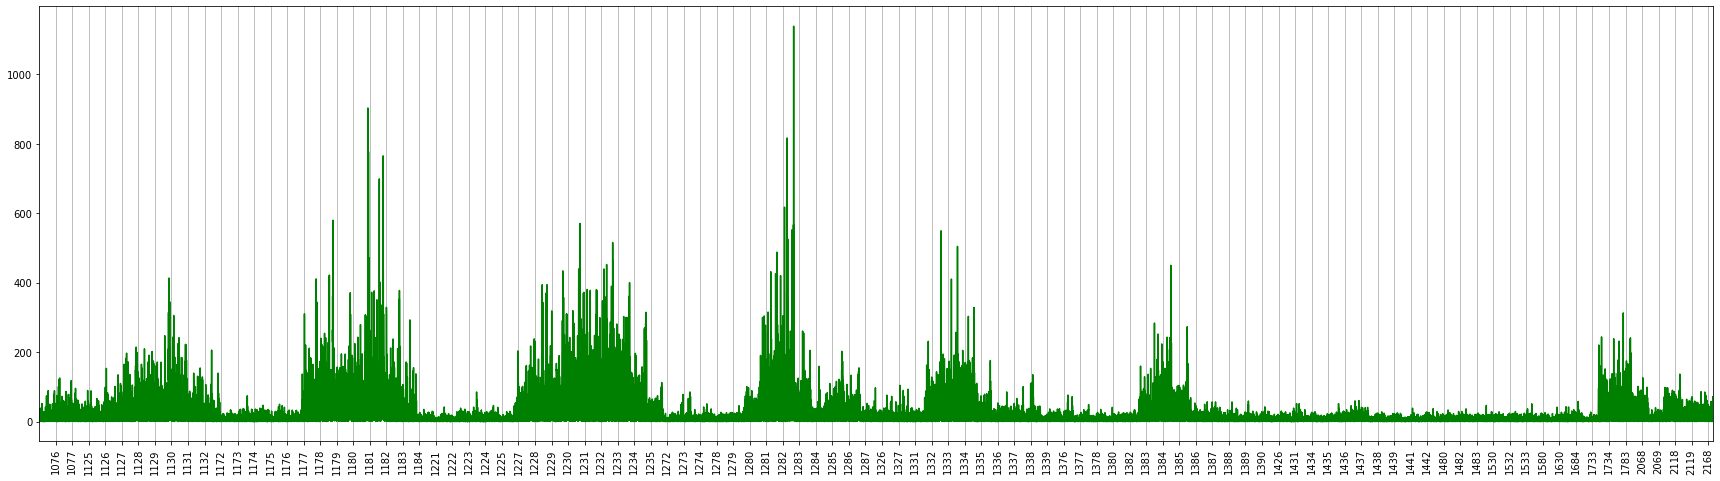

In [10]:
plot_errors(errors)

Видно, что на некоторых зонах возникают отклонения от прогноза выше среднего. Попробуем разобраться, в чем дело

Наложим графики ошибок по зонам друг на друга, чтобы выявить закономерности

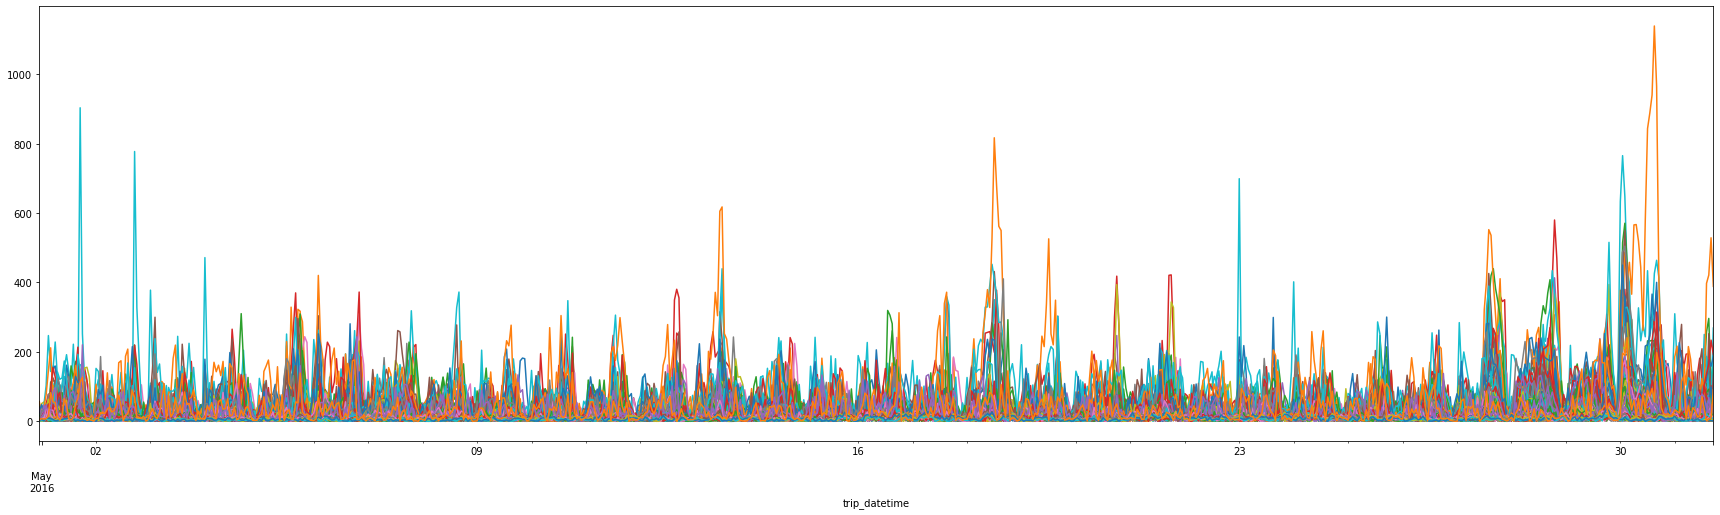

In [11]:
for region in errors.region_id.unique():
    errors[errors.region_id==region].loc[:, '6'].plot(figsize=(30,8))

По графикам видно, что у ошибки на некоторых рядах выражена суточная сезонность. Кроме того, в конце мая виден всплеск, это связано с праздником Memorial Day. Необходимо будет учесть государственные праздники США, причем как сам день праздника, так и дни до/после праздника, т.к. видно, что ошибка накануне праздника также возрастает.

Посмотрим графики прогноза на зонах с самыми большими отклонениями

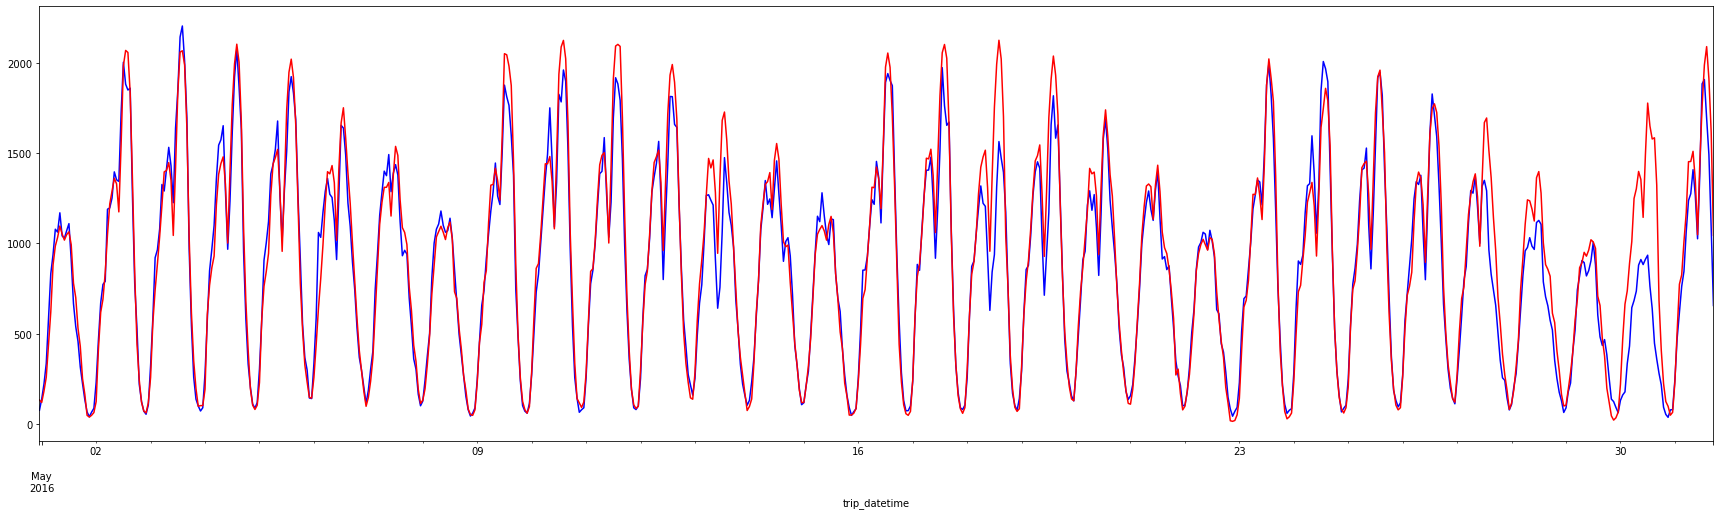

In [16]:
# зона 1282, максимальное отклонение больше 1000
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1282
)

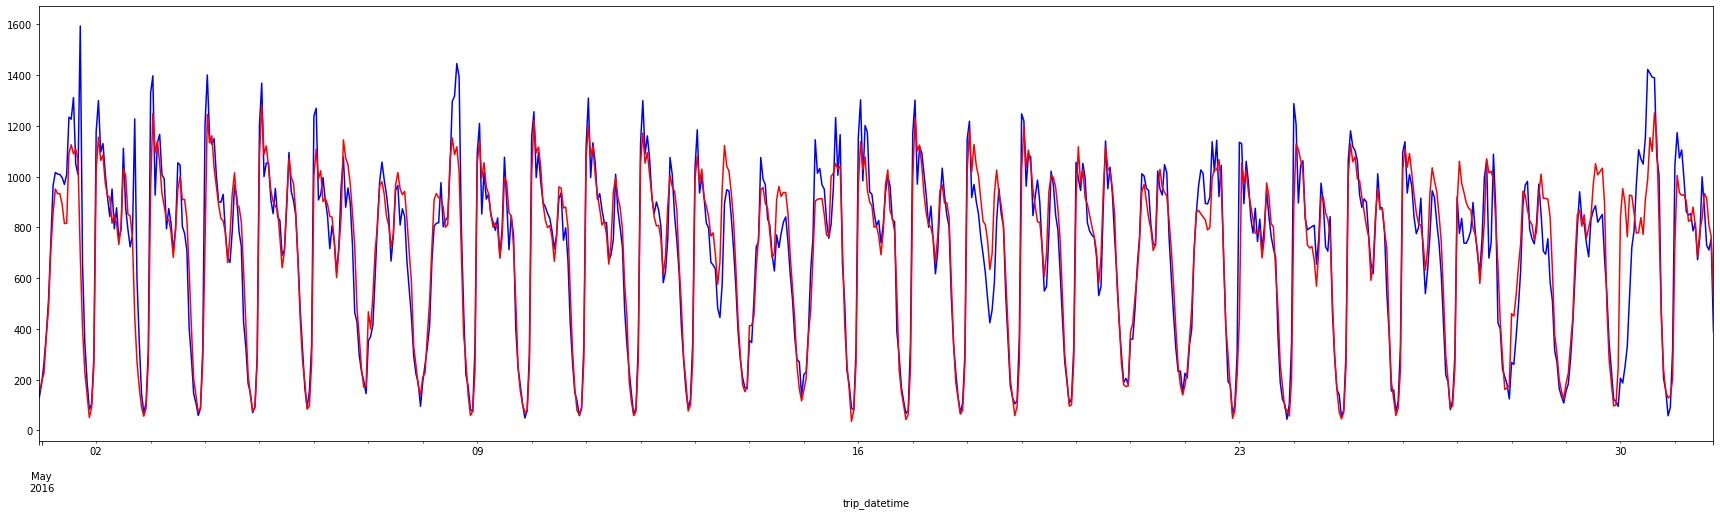

In [17]:
# зона 1181, ошибка в среднем ~ 400
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1181
)

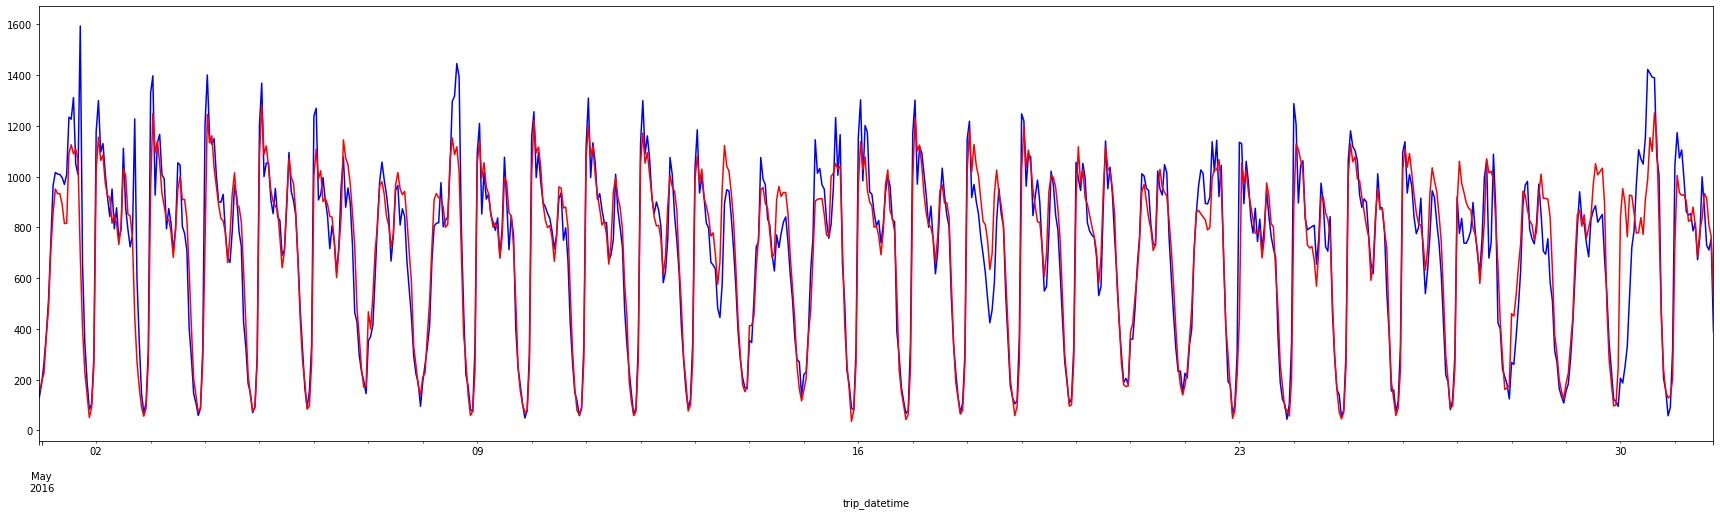

In [18]:
# зона 1333, ошибка в среднем ~ 200
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1181
)

На всех графиках есть одна особенность - ошибка довольно большая при прогнозировании на пиках. Попробуем решить эту проблему.

Для этого сделаем небольшой рефакторинг класса TaxiTripTransformer: уменьшим количество фурье-гармоник, а также добавим новый признак - разницу между текущим количеством поездок и их средним значением по дням/часам. Возможно, это поможет улучшить качество прогноза в пиковых значениях

In [19]:
# модифицированный класс TaxiTripTransformer
class TaxiTripTransformer(TransformerMixin):
    def __init__(self, series_index, *additional_transformers):
        self.series_index = series_index
        self._additional_transformers = additional_transformers

    def _fourier_harmonic(self, X, series_index, k_values, period):
        values = np.array([series_index.get_loc(n) for n in X.index.values])
        
        return csr_matrix(
            np.array([
                func(values*2*math.pi*k/period) for k in k_values for func in (np.sin, np.cos)
            ]).T
        )
    
    def _mean_by_hour(self, X):
        df = X.copy()
        df.loc[:, 'hour'] = df.index.hour
        df.loc[:, 'dayofweek'] = df.index.dayofweek
        
        return (
            df.pivot_table(
                values='trip_count_sum', 
                index=['dayofweek','hour'],
                columns='region_id',
                fill_value=0
            )
            .groupby(['dayofweek','hour'])
            .mean()
        )
    
    def _get_pivot_table(self, X):
        return X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )
    
    def _shift_function(self, X, range_func):
        df_defauls = self._mean_by_hour(X)
        X_pivot = self._get_pivot_table(X)

        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(
                    X_pivot
                    .head(hour)
                    .apply(
                        lambda x: df_defauls.loc[(
                            (x.name-pd.Timedelta(hours=hour)).dayofweek,
                            (x.name-pd.Timedelta(hours=hour)).hour
                        )], 
                        axis=1
                    )
                )
                .stack()
                for hour in range_func
            ]).T
        )

    def _sum_function(self, X, periods):
        X_pivot = self._get_pivot_table(X)
        return csr_matrix(
            np.array([
                X_pivot
                .rolling(window = period)
                .sum()
                .shift()
                .fillna(X_pivot.mean())
                .stack()
                for period in periods
            ]).T
        )
    
    def _mean_deviation(self, X, shift_hours):
        df_mean = self._mean_by_hour(X)
        X_pivot = self._get_pivot_table(X)
        
        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(0)
                .apply(
                    lambda x: x - df_mean.loc[(
                        (x.name-pd.Timedelta(hours=hour)).dayofweek,
                        (x.name-pd.Timedelta(hours=hour)).hour
                    )], 
                    axis=1
                )
                .stack()
                for hour in shift_hours
            ]).T
        )
    
    def _feature_union(self):
        return FeatureUnion(
            n_jobs = -1,
            transformer_list = [

                # недельные гармоники
                ('week_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=[2,3,4,5,7,9,12,14],
                                period=24*7
                            )
                        )),
                    ]
                )),

                # годовые гармоники
                ('year_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index,
                                k_values=[2,30,91,182,365],
                                period=24*365.25
                            )
                        )),
                    ]
                )),
                
                # идентификатор географической зоны
                ('region_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.region_id), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # год
                ('year_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.year), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # номер месяца
                ('month_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.month), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # день недели
                ('dayofweek_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.dayofweek), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),                        

                # часы
                ('hour_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.hour), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # количество поездок 1..24 часов назад
                ('trip_hour_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(1, 24+1, 1)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # количество поездок 24..168 часов назад
                ('trip_day_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=range(24, 24*7+1, 24)
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                   ]
                )),

                # суммарное количество поездок за полдня, день, неделю, месяц
                ('trip_sum_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._sum_function(
                                X=data,
                                periods=[12, 24, 24*7, 24*30]
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),
                
                # отклонение от среднего числа поездок
                ('mean_deviation_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._mean_deviation(
                                X=data,
                                shift_hours=[0,1,2,3,6,12,24,24*7]
                            ), validate=False
                        )),
                        ('scaling',StandardScaler(with_mean=False))
                    ]
                )),
                
                # дополнительные признаки
                *self._additional_transformers
            ]
        )
    
    def fit_transform(self, X):
        return self._feature_union().fit_transform(X)

In [20]:
del trip_data
trip_data = TripData(data)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.29640327937171


Ошибка уменьшилась на 3.5 единицы, в целом, это неплохой результат. Попробуем добавить другие признаки.

##### 2.2
Добавим государственные праздники США, плюс несколько дней до и после праздника

In [21]:
from pandas.tseries.holiday import USFederalHolidayCalendar

holidays = pd.DataFrame(
    USFederalHolidayCalendar().holidays(
        start=data.index.min(), 
        end=data.index.max(),
        return_name=True
    )
)

holidays.columns=['name']

shift_holidays=[]
for i in range(-2, 3):
    shift_holidays.append(
        holidays
        .shift(i, freq='D')
        .name
        .add('_{}'.format(i))
    )

holidays = pd.DataFrame(pd.concat(shift_holidays))

additional_transformers = [
    
    # государственные праздники
    ('holiday_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: (
                    data.join(other=holidays, how='left')
                    .loc[:, ['name']]
                    .fillna('Non-Holiday')
                ), validate=False)
            ),
            ('hot_encoding', OneHotEncoder(categories='auto')),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.133729967813455


Ошибка уменьшилась, но незначительно. Посмотрим, сохранилась ли аномалия 30 мая (Memory Day)

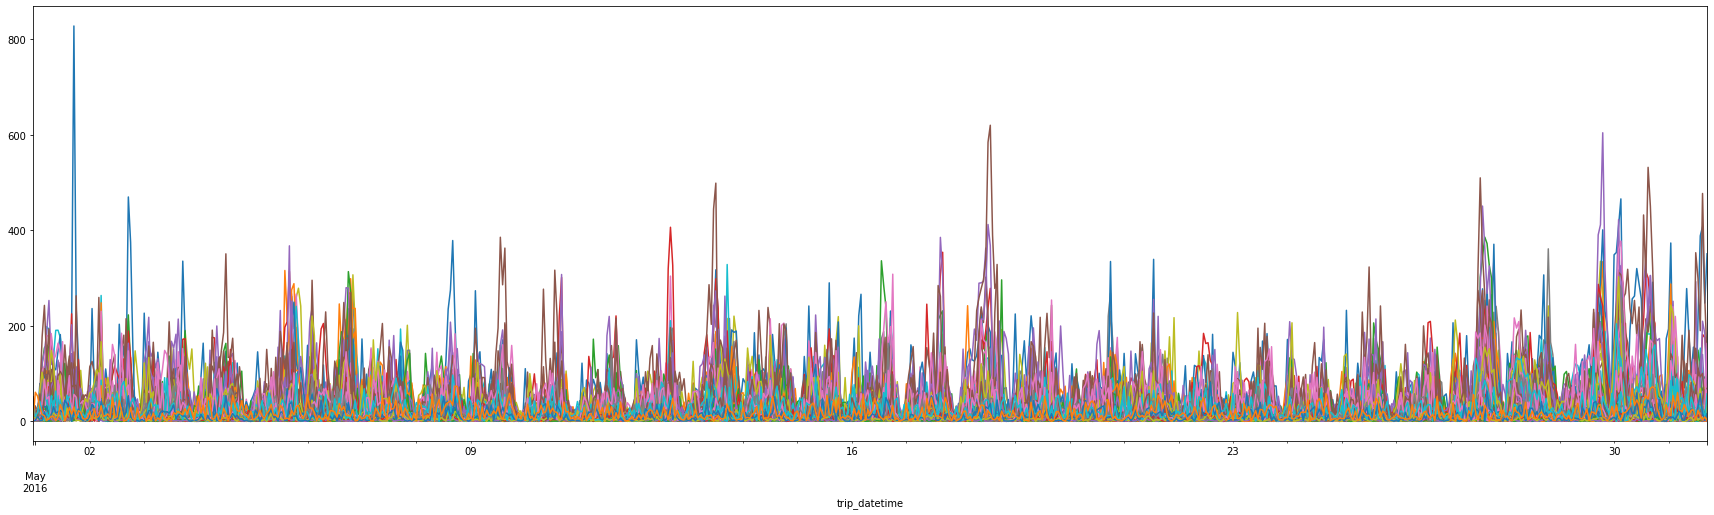

In [22]:
for region in errors.region_id.unique():
    errors[errors.region_id==region].loc[:, '6'].plot(figsize=(30,8))

Судя по графику, аномалия 30 мая стала меньше, признак можно считать полезным.

##### 2.3
Добавим новые признаки:

    средняя длительность поездок
    среднее количество пассажиров
    среднее расстояние по счётчику
    средняя стоимость поездок
   
Протестируем их отдельно от государственных праздников, чтобы оценить их непосредственное влияние на улучшение качества прогноза

In [23]:
additional_transformers = [
    
    # средняя длительность поездок
    ('duration_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: pd.DataFrame(data.trip_duration_mean), validate=False)
            ),
            ('scaling', StandardScaler(with_mean=False)),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.141286219538923


In [24]:
additional_transformers = [
    
    # среднее количество пассажиров
    ('passenger_count_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: pd.DataFrame(data.passenger_count_mean), validate=False)
            ),
            ('scaling', StandardScaler(with_mean=False)),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.26776741360218


In [25]:
additional_transformers = [
    
    # среднее расстояние по счётчику
    ('distance_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: pd.DataFrame(data.trip_distance_mean), validate=False)
            ),
            ('scaling', StandardScaler(with_mean=False)),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.19417359193057


In [26]:
additional_transformers = [
    
    # средняя стоимость поездок
    ('total_amount_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: pd.DataFrame(data.total_amount_mean), validate=False)
            ),
            ('scaling', StandardScaler(with_mean=False)),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.32229607078022


По сравнению с оценкой, полученной в п. 2.1 (18.296) уменьшилась ошибка добавлении признаков:

    средняя длительность поездки(18.14)
    среднее расстояние по счётчику(18.19)

Остальные признаки какого-либо повышения качества модели не дали

##### 2.4
Добавим новый признак - десятичный логарифм от числа поездок, проверим, улучшит ли это качество.

In [27]:
additional_transformers = [
    
    # десятичный логарифм от числа поездок
    ('log10_count_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: pd.DataFrame(
                    np.where(
                        data.trip_count_sum>0, 
                        np.log10(data.trip_count_sum), 
                        0
                    )
                ), validate=False)
            ),
            ('scaling', StandardScaler(with_mean=False)),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.138685428623198


По сравнению с оценкой, полученной в п. 2.1 (18.296) ошибка уменьшилась.

##### 2.5
Попробуем кластеризовать данные и использовать идентификатор кластера в качестве признака

Так как сложно определить "правильную" кластеризацию, сделаем кластеры тремя различными алгоритмами - агломеративной кластеризацией, методом распространения близости, методом k средних и добавим в модель.

In [30]:
from sklearn.cluster import AgglomerativeClustering, AffinityPropagation, MiniBatchKMeans

def plot_series(series, clusters):
    clusterset = set(clusters.values())
    fig, axes = plt.subplots(
        nrows=math.ceil(len(clusterset)/2), 
        ncols=2, 
        figsize=(30, 30)
    )
    for i, clustername in enumerate(clusterset):
        r, c = math.floor(i/2), i%2
        axes[r, c].set_title('cluster {}'.format(clustername))
        axes[r, c].plot(
            series
            .head(24*7)
            .loc[:, [key for key, value in clusters.items() if value==clustername]]
        )
        
def clustering(model, df, values='trip_count_sum'):
    series = df.pivot_table(
        values=values, 
        index='trip_datetime', 
        columns='region_id',
        fill_value=0
    )
    series.iloc[:,:] = Normalizer().fit_transform(series.astype(float))
    samples = series.values.T
    
    model = model.fit(samples)
    clusters = dict(
        zip(
            series.columns.values, 
            model.labels_
        )
    )
    plot_series(series, clusters)
    
    return pd.DataFrame.from_dict(clusters, orient='index')

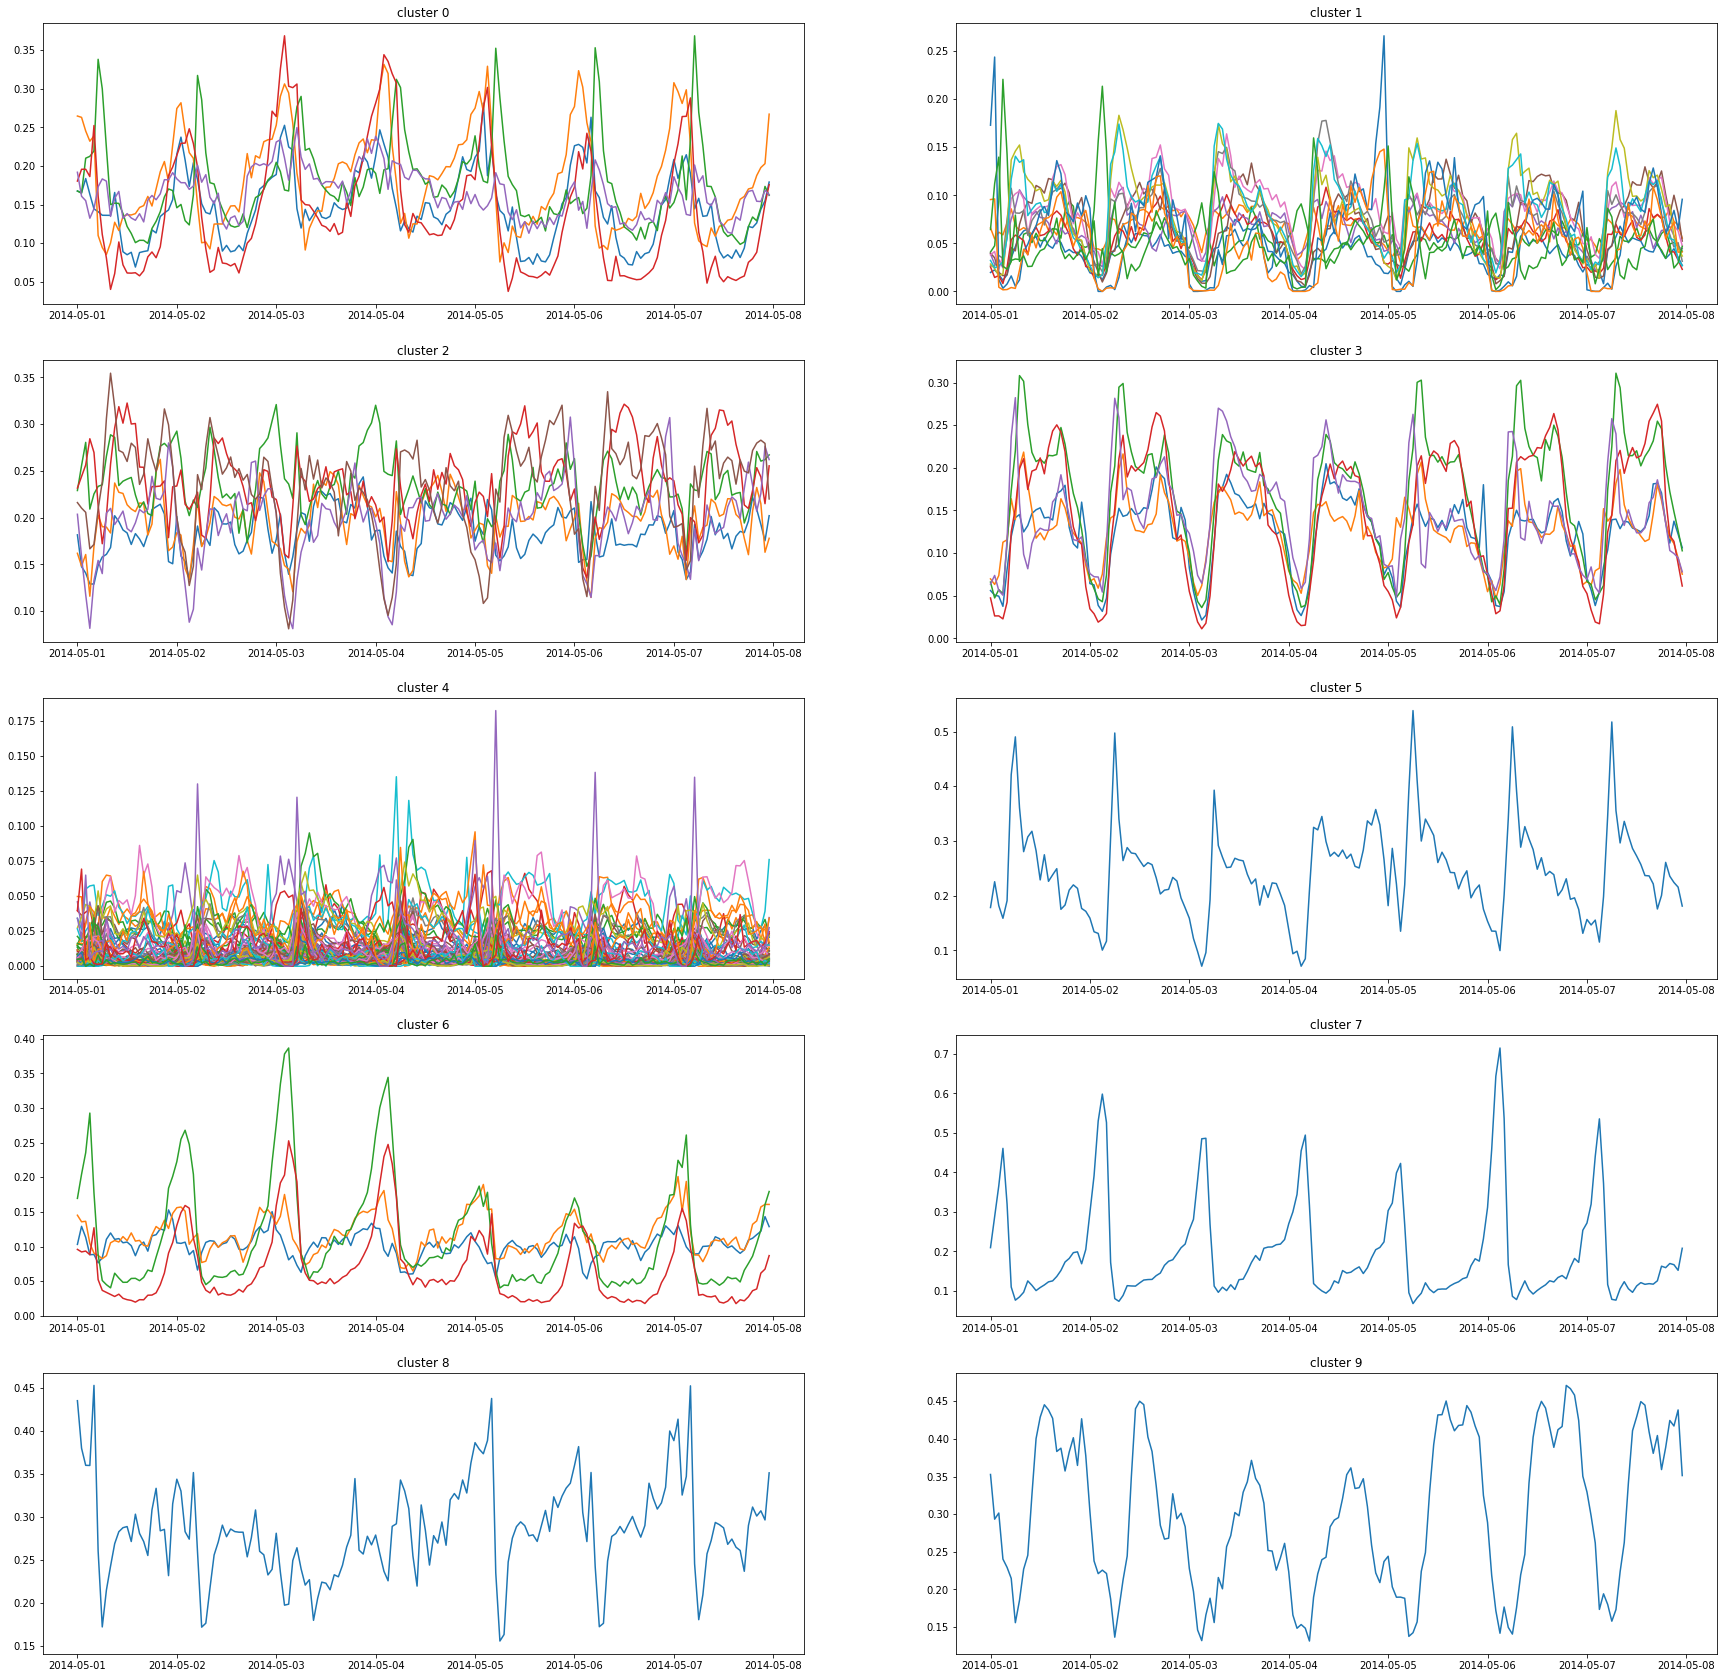

In [37]:
#AgglomerativeClustering
agglomerative_clusters = clustering(
    AgglomerativeClustering(
        n_clusters=10,
        affinity='l2',
        linkage='complete'
    ),
    data
)

При данном разбиении на кластеры получается визуально наиболее приемлемая картина. Видно, что в кластеры выделились как одинаковые по форме ряды, так и по размаху колебаний (использовалась нормализация). Так же, выделились отдельные ряды, которые очень нетипичны.

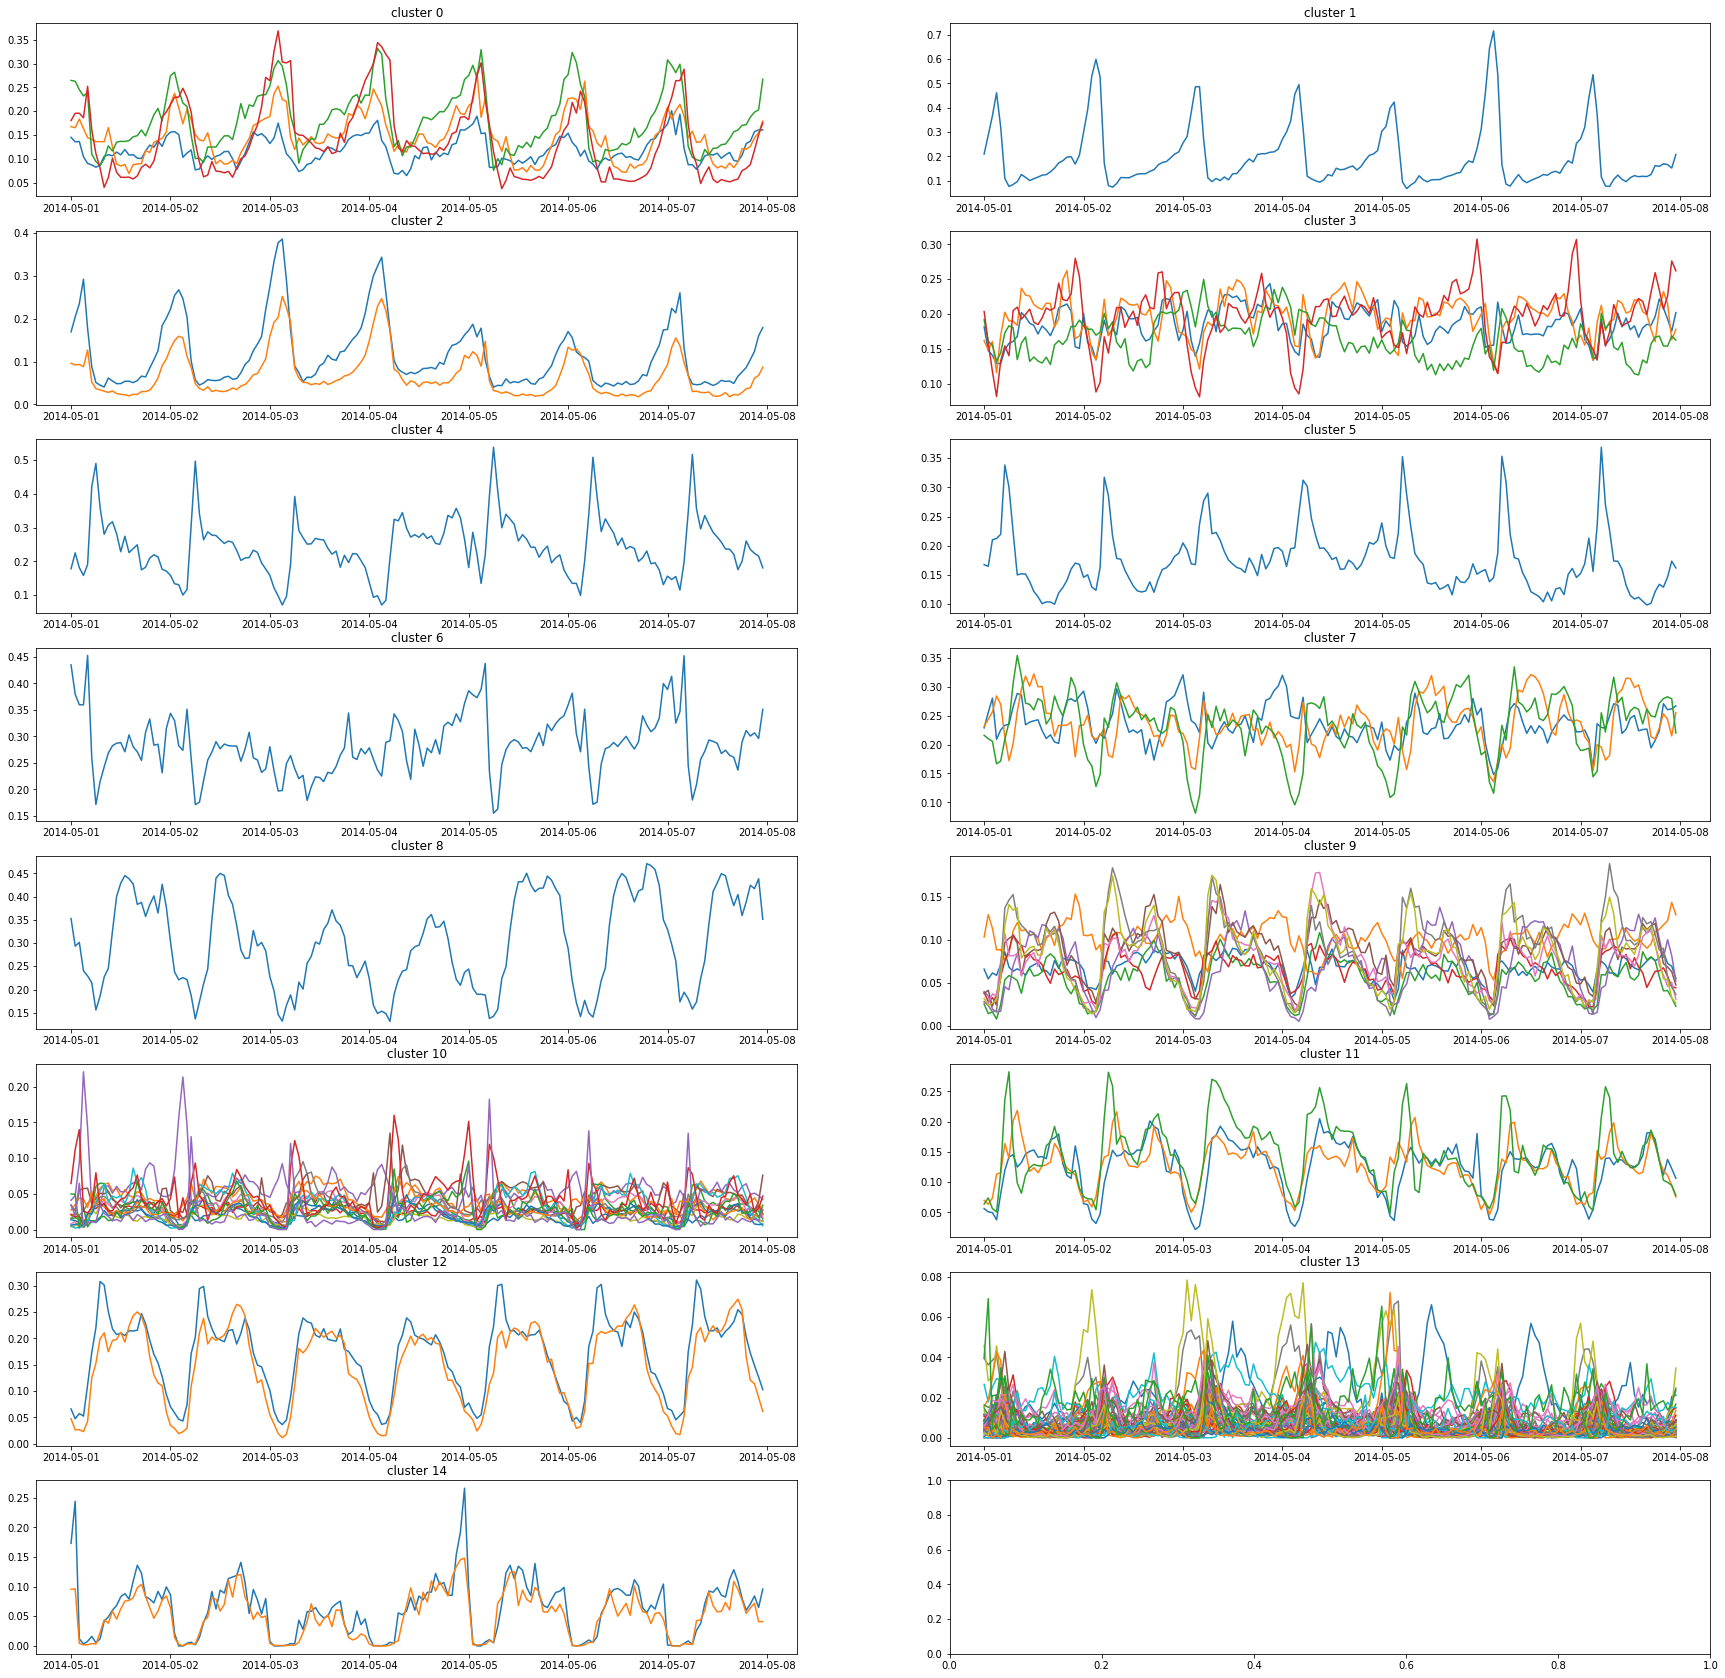

In [48]:
#AffinityPropagation
affinity_clusters = clustering(
    AffinityPropagation(
        damping=0.85,
        max_iter=1000
    ),
    data
)

В целом, тоже получилось неплохое разбиение на кластеры. Выделились те же нетипичные ряды, плюс добавился еще один.

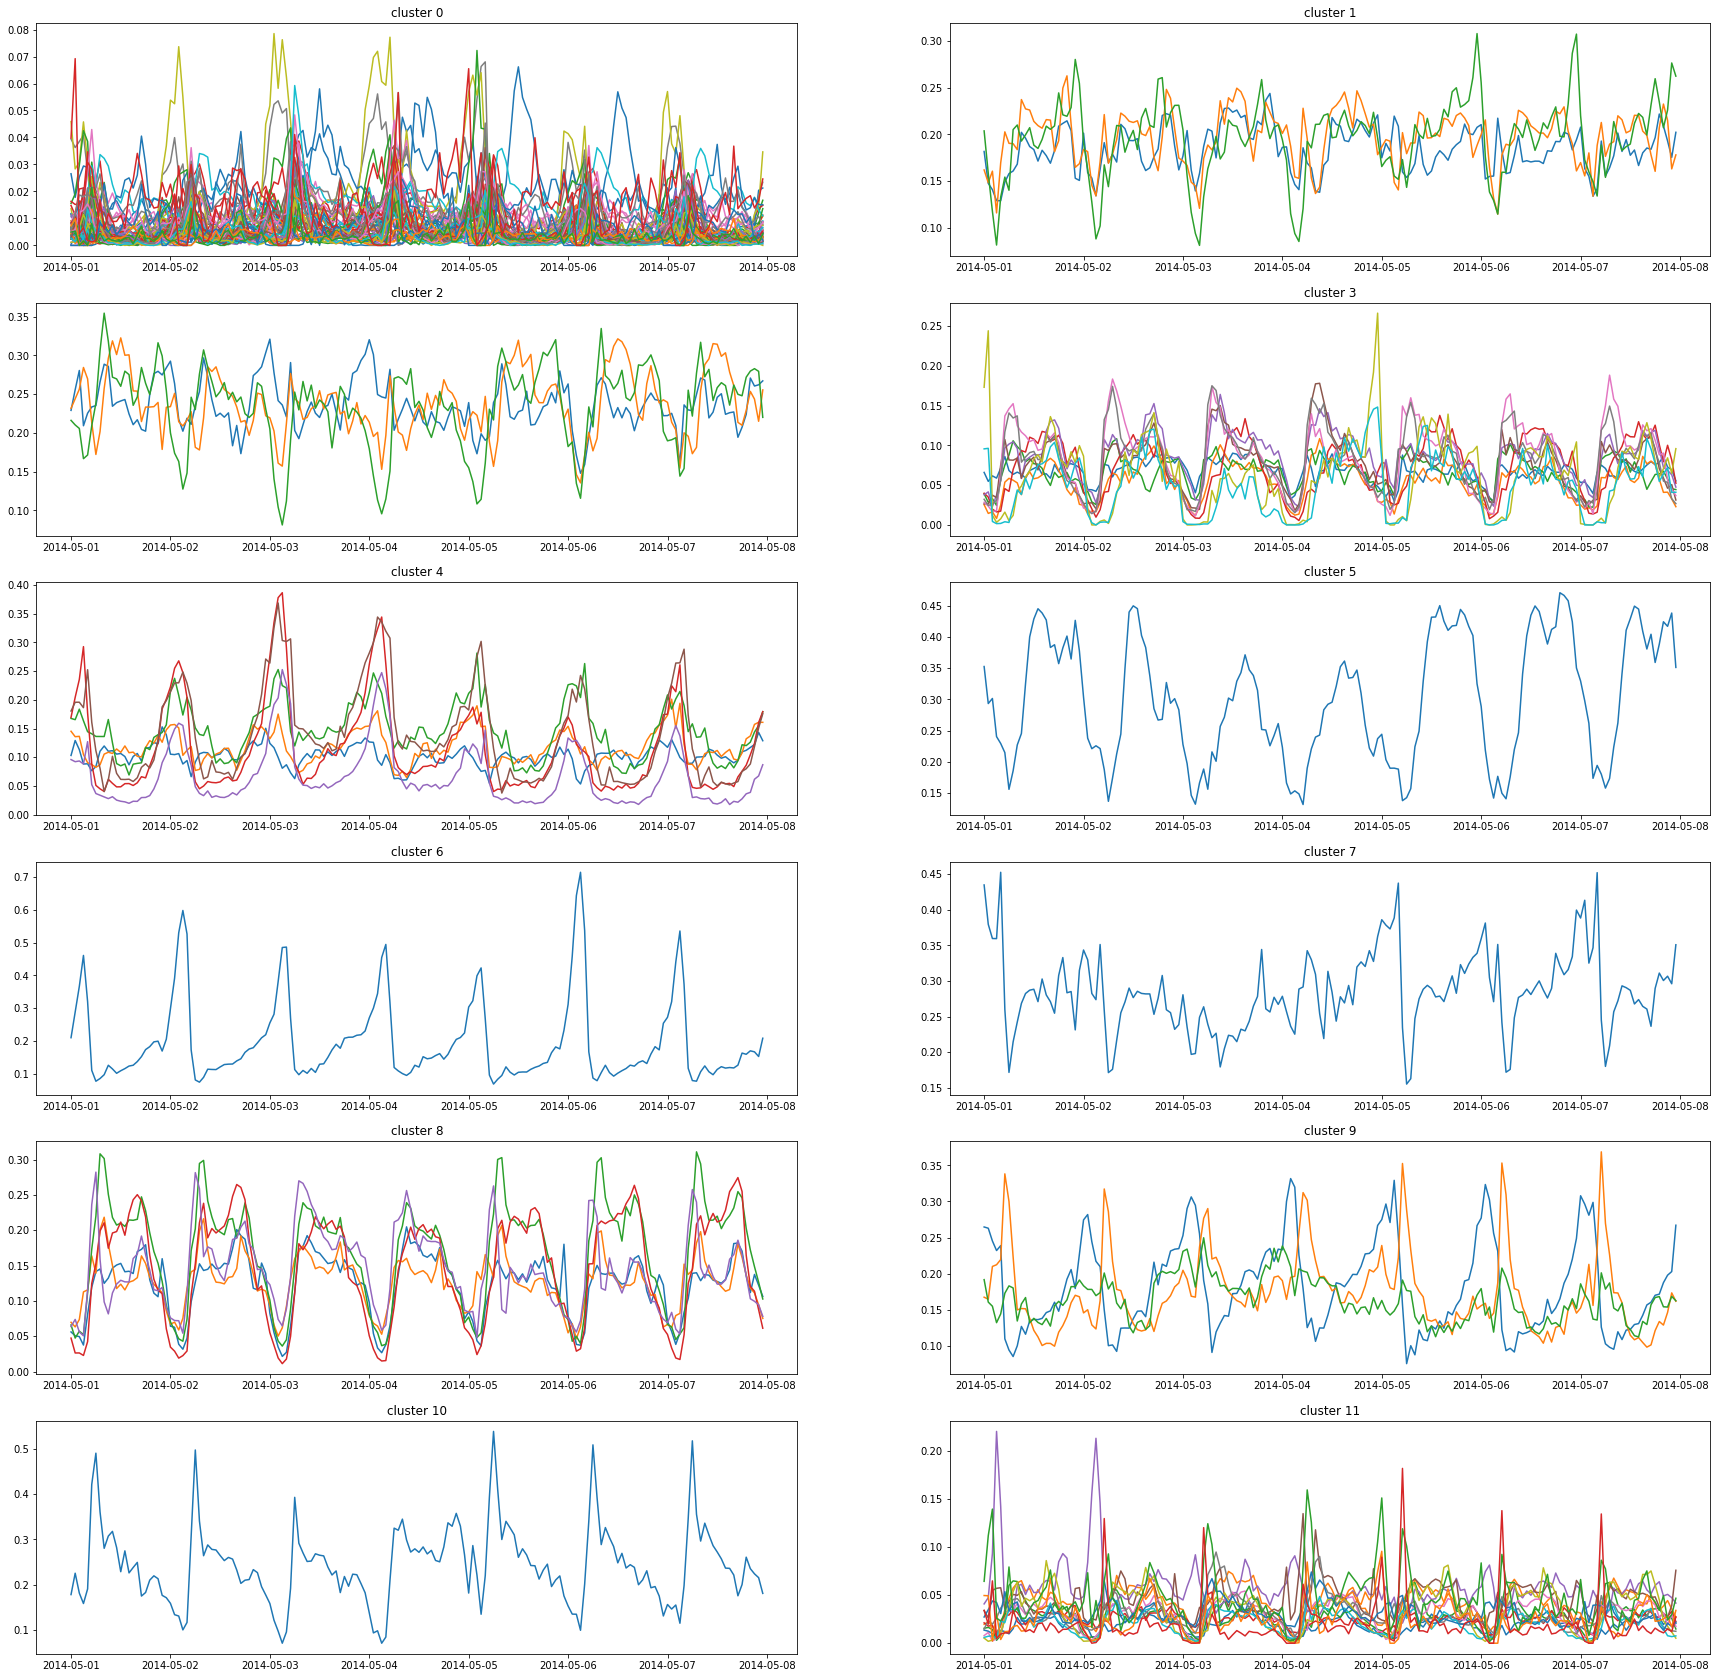

In [68]:
#MiniBatchKMeans
kmeans_clusters = clustering(
    MiniBatchKMeans(
        max_iter=1000,
        n_clusters=12
    ),
    data
)

Еще один вариант разбиения, в целом, тоже неплохой

In [70]:
# переименуем поля, чтобы при джойне не было ошибок
for clusters, name in [
    [kmeans_clusters, 'kmeans'],
    [affinity_clusters, 'affinity'],
    [agglomerative_clusters, 'agglomerative']
]:
    clusters.columns=[name]

In [77]:
additional_transformers = [
    
    # идентификаторы кластеров
    ('cluster_processing', Pipeline(
        steps = [
            ('selecting', FunctionTransformer(
                lambda data: (
                    data
                    .set_index('region_id')
                    .join(other=kmeans_clusters, how='left')
                    .join(other=affinity_clusters, how='left')
                    .join(other=agglomerative_clusters, how='left')
                    .iloc[:, -3:]
                ), validate=False)
            ),
            ('hot_encoding', OneHotEncoder(categories='auto')),
        ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 18.141645673509316


По сравнению с оценкой, полученной в п. 2.1 (18.296) ошибка уменьшилась.

##### 2.6
Попробуем проверить гипотезу: прогнозное количество поездок на 1..6 часов вперед близко к аналогичному количеству поездок неделю назад

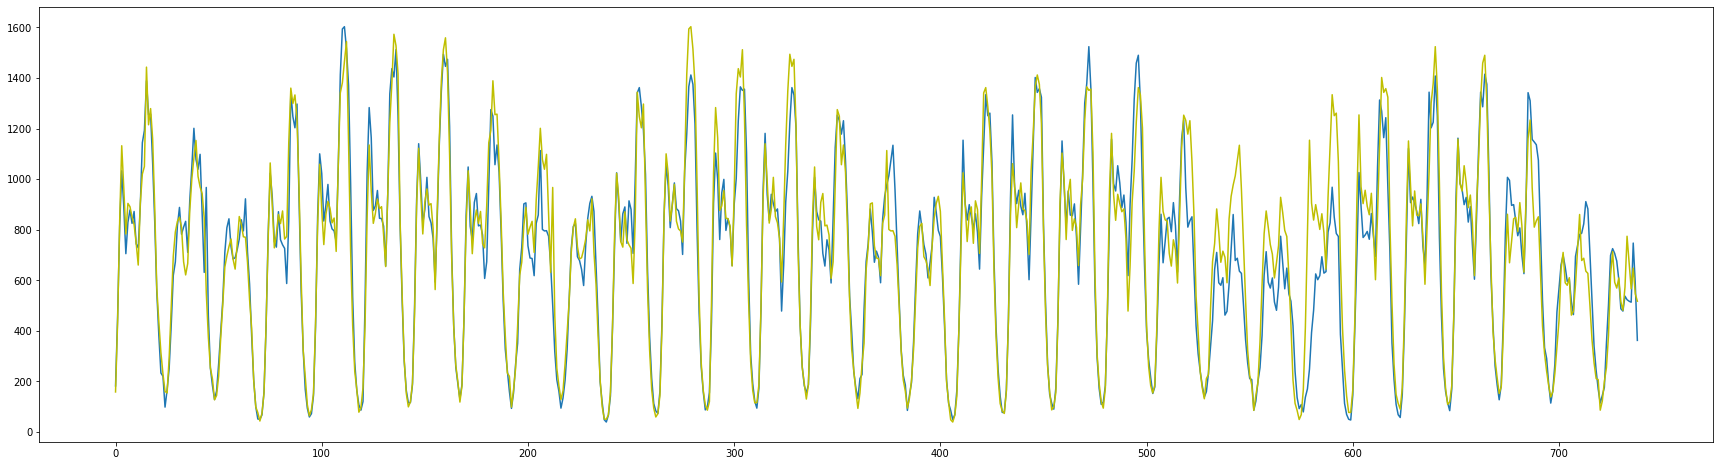

In [15]:
# количество поездок в регионе 1281 в мае 2016
(
    data[data.region_id==1281]
    .loc[slice('2015-05-01 05:00:00','2015-05-31 23:00:00')]
    .reset_index()
    .trip_count_sum
    .plot(figsize=(30,8))
)

# количество поездок в регионе 1281 со сдвигом в неделю
(
    data[data.region_id==1281]
    .loc[slice('2015-04-24 05:00:00','2015-05-24 23:00:00')]
    .reset_index()
    .trip_count_sum
    .plot(figsize=(30,8), color='y')
)

Видно, что корреляция очень высокая. Исходя из этого, попробуем добавить 2 новых признака:
    
    1) количество поездок в прогнозное время, со сдвигом в неделю, 2 недели, месяц
    2) отклонение текущего количества поездок от количества поездок неделю, 2 недели, месяц назад.

Так мы попробуем решить проблему ошибок прогноза в пиках, исходя из двух идей:
    
    1) структуры графика количества поездок сейчас и неделю назад очень близки, потому новый признак по сути должен быть близок к авторегрессии
    2) разница между количеством поездок сейчас и неделю назад будет моделировать возможную ошибку прогноза в п.1

In [23]:
def diff_function(X, diff_hours):
    X_pivot = X.pivot_table(
        values='trip_count_sum', 
        index='trip_datetime', 
        columns='region_id',
        fill_value=0
    )

    return csr_matrix(
        np.array([
            X_pivot
            .diff(hour)
            .fillna(0)
            .stack()
            for hour in diff_hours
        ]).T
    )

shift_function = TaxiTripTransformer(None)._shift_function

additional_transformers = [
    
    # количество поездок 24*n-{1..6} часов назад
    ('trip_shift_processing', Pipeline(
        steps = [
            ('calculation', FunctionTransformer(
                lambda data: shift_function(
                    X=data,
                    range_func=[hour for n in [7,14,28] for hour in range(24*n-6, 24*n, 1)]
                )
            )),
            ('scaling', StandardScaler(with_mean=False))
       ]
    )),

    # разница между текущим количеством поездок и 24*7..24*7*n часов назад
    ('trip_diff_processing', Pipeline(
        steps = [
            ('calculation', FunctionTransformer(
                lambda data: diff_function(
                    X=data,
                    diff_hours=[24*7, 24*14, 24*28]
                )
            )),
            ('scaling', StandardScaler(with_mean=False))
       ]
    )),
]

del trip_data
trip_data = TripData(data, *additional_transformers)
predictions, errors = calc_predictions_may(trip_data)

build model for T=6
Средняя абсолютная ошибка прогноза: 16.983887839727796


По сравнению с оценкой, полученной в п. 2.1 (18.296) ошибка уменьшилась и довольно значительно (на 1.3)

##### 2.7
Добавим все признаки, на которых ошибку удалось уменьшить, и подберем еще раз гиперпараметры

Для удобства параметры добавим сразу в класс-транформер

In [26]:
# класс-сплитер исходных данных на выборки
class TripData():
    def __init__(self, data, *additional_transformers):
        self.date_index = data.index.unique()
        self._additional_transformers = additional_transformers
        self.data = (
            data.reset_index()
            .sort_values(['trip_datetime', 'region_id'])
            .set_index('trip_datetime')
        )
        self._fit_X_y()
    
    def _fit_X_y(self):
        
        self.train_idx = np.where(self.data.index.isin(self.data.loc[:'2016-04-30 17:00:00'].index))[0]
        self.test_idx = np.where(self.data.index.isin(self.data.loc['2016-04-30 23:00:00':'2016-05-31 17:00:00'].index))[0]
        self.final_idx = np.where(self.data.index.isin(self.data.loc['2016-05-31 23:00:00':'2016-06-30 17:00:00'].index))[0]
        self._transformer = TaxiTripTransformer(self.date_index, *self._additional_transformers)
        self._X = self._transformer.fit_transform(self.data)
    
    def _shift_y(self, data, T):
        region_count = data.region_id.unique().shape[0]
        return data.shift(-T*region_count).fillna(0).trip_count_sum
    
    def unsplit(self, T):
        return SimpleNamespace(
            X=self._X,
            y=self._shift_y(self.data, T)
        )
    
    def train(self, T):
        X=self._X[np.where(self.data.index.isin(self.data.loc[:'2016-05-31 17:00:00'].index))[0]]
        y=self._shift_y(
                self.data.loc[:'2016-05-31 23:00:00'],
                T
            ).iloc[: X.shape[0]]
        
        return SimpleNamespace(
            X=X,
            y=y
        )
    
    def test(self, T):
        X = self._X[self.final_idx]
        y = self._shift_y(
            self.data.loc['2016-06-01 00:00:00':'2016-06-30 23:00:00'],
            T
        ).iloc[: X.shape[0]]
        
        return SimpleNamespace(
            X=X,
            y=y
        )
    
    def cv(self):
        yield (
            self.train_idx,
            self.test_idx
        )
        
    def get_feature_names(self):
        return self._transformer.get_feature_names()

# класс TaxiTripTransformer с новыми признаками
class TaxiTripTransformer(TransformerMixin):
    def __init__(self, series_index, *additional_transformers):
        self.series_index = series_index
        self._feature_names = []
        self._additional_transformers = additional_transformers
        self._params = self._get_params()
        
    def _get_params(self):
        return SimpleNamespace(
            week_harmonic_k_values = [2,3,4,5,7,9,12,14],
            year_harmonic_k_values = [2,30,91,182,365],
            trip_hour_range = range(1, 24+1, 1),
            trip_day_range = range(24, 24*7+1, 24),
            trip_shift_range = [i for n in [7,14,28] for i in range(24*n-6, 24*n, 1)],
            trip_diff_hours = [24*7, 24*14, 24*28],
            trip_sum_periods = [12, 24, 24*7, 24*30],
            mean_deviation_shift_hours = [0,1,2,3,6,12,24,24*7,24*7-1,24*7-2,24*7-3,24*7-4,24*7-5,24*7-6]
        )

    def _fourier_harmonic(self, X, series_index, k_values, period):
        values = np.array([series_index.get_loc(n) for n in X.index.values])
        return csr_matrix(
            np.array([
                func(values*2*math.pi*k/period) for k in k_values for func in (np.sin, np.cos)
            ]).T
        )
    
    def _mean_by_hour(self, X):
        df = X.copy()
        df.loc[:, 'hour'] = df.index.hour
        df.loc[:, 'dayofweek'] = df.index.dayofweek
        
        return (
            df.pivot_table(
                values='trip_count_sum', 
                index=['dayofweek','hour'],
                columns='region_id',
                fill_value=0
            )
            .groupby(['dayofweek','hour'])
            .mean()
        )
    
    def _get_pivot_table(self, X):
        return X.pivot_table(
            values='trip_count_sum', 
            index='trip_datetime', 
            columns='region_id',
            fill_value=0
        )
    
    def _shift_function(self, X, range_func):
        df_defauls = self._mean_by_hour(X)
        X_pivot = self._get_pivot_table(X)

        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(
                    X_pivot
                    .head(hour)
                    .apply(
                        lambda x: df_defauls.loc[(
                            (x.name-pd.Timedelta(hours=hour)).dayofweek,
                            (x.name-pd.Timedelta(hours=hour)).hour
                        )], 
                        axis=1
                    )
                )
                .stack()
                for hour in range_func
            ]).T
        )

    def _sum_function(self, X, periods):
        X_pivot = self._get_pivot_table(X)
        return csr_matrix(
            np.array([
                X_pivot
                .rolling(window = period)
                .sum()
                .shift()
                .fillna(X_pivot.mean())
                .stack()
                for period in periods
            ]).T
        )
    
    def _diff_function(self, X, diff_hours):
        X_pivot = self._get_pivot_table(X)
        
        return csr_matrix(
            np.array([
                X_pivot
                .diff(hour)
                .fillna(0)
                .stack()
                for hour in diff_hours
            ]).T
        )
    
    def _mean_deviation(self, X, shift_hours):
        df_mean = self._mean_by_hour(X)
        X_pivot = self._get_pivot_table(X)
        
        return csr_matrix(
            np.array([
                X_pivot
                .shift(hour)
                .fillna(0)
                .apply(
                    lambda x: x - df_mean.loc[(
                        (x.name-pd.Timedelta(hours=hour)).dayofweek,
                        (x.name-pd.Timedelta(hours=hour)).hour
                    )], 
                    axis=1
                )
                .stack()
                for hour in shift_hours
            ]).T
        )
    
    def _get_holidays(self):
        holidays = pd.DataFrame(
            USFederalHolidayCalendar().holidays(
                start=self.series_index.min(), 
                end=self.series_index.max(),
                return_name=True
            )
        )
        holidays.columns=['name']

        shift_holidays=[]
        for i in range(-2, 3):
            shift_holidays.append(
                holidays
                .shift(i, freq='D')
                .name
                .add('_{}'.format(i))
            )

        return pd.DataFrame(pd.concat(shift_holidays))
    
    
    def _clustering(self, X, model):
        series = self._get_pivot_table(X)
        series.iloc[:,:] = Normalizer().fit_transform(series.astype(float))
        samples = series.values.T

        model = model.fit(samples)
        clusters = dict(
            zip(
                series.columns.values, 
                model.labels_
            )
        )

        return pd.DataFrame.from_dict(clusters, orient='index')
    
    def _get_clusters(self, X):
        agglomerative_clusters = self._clustering(
            X=X,
            model=AgglomerativeClustering(
                n_clusters=10,
                affinity='l2',
                linkage='complete'
            )
        )

        affinity_clusters = self._clustering(
            X=X,
            model=AffinityPropagation(
                damping=0.85,
                max_iter=1000
            )
        )

        kmeans_clusters = self._clustering(
            X=X,
            model=MiniBatchKMeans(
                max_iter=1000,
                n_clusters=12
            )
        )
        
        for clusters, name in [
            [kmeans_clusters, 'kmeans'],
            [affinity_clusters, 'affinity'],
            [agglomerative_clusters, 'agglomerative']
        ]:
            clusters.columns=[name]
        
        return (
            X.set_index('region_id')
            .join(other=kmeans_clusters, how='left')
            .join(other=affinity_clusters, how='left')
            .join(other=agglomerative_clusters, how='left')
            .iloc[:, -3:]
        )
        
    
    def _feature_union(self):
        return FeatureUnion(
            n_jobs = -1,
            transformer_list = [

                # недельные гармоники
                ('week_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index, 
                                k_values=self._params.week_harmonic_k_values,
                                period=24*7
                            )
                        )),
                    ]
                )),

                # годовые гармоники
                ('year_harmonic_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._fourier_harmonic(
                                X=data, 
                                series_index=self.series_index,
                                k_values=self._params.year_harmonic_k_values,
                                period=24*365.25
                            )
                        )),
                    ]
                )),
                
                # идентификатор географической зоны
                ('region_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.region_id), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # год
                ('year_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.year), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # номер месяца
                ('month_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.month), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # день недели
                ('dayofweek_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.dayofweek), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),                        

                # часы
                ('hour_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.index.hour), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),

                # количество поездок 1..24 часов назад
                ('trip_hour_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=self._params.trip_hour_range
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),

                # количество поездок 24..168 часов назад
                ('trip_day_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=self._params.trip_day_range
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                   ]
                )),
                
                # количество поездок 24*n-{1..6} часов назад
                ('trip_shift_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._shift_function(
                                X=data,
                                range_func=self._params.trip_shift_range
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                   ]
                )),

                # разница между текущим количеством поездок и 24*7..24*7*n часов назад
                ('trip_diff_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._diff_function(
                                X=data,
                                diff_hours=self._params.trip_diff_hours
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                   ]
                )),

                # суммарное количество поездок за полдня, день, неделю, месяц
                ('trip_sum_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._sum_function(
                                X=data,
                                periods=self._params.trip_sum_periods
                            )
                        )),
                        ('scaling', StandardScaler(with_mean=False))
                    ]
                )),
                
                # средняя длительность поездок
                ('duration_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.trip_duration_mean), validate=False)
                        ),
                        ('scaling', StandardScaler(with_mean=False)),
                    ]
                )),
                
                # среднее расстояние по счётчику
                ('distance_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(data.trip_distance_mean), validate=False)
                        ),
                        ('scaling', StandardScaler(with_mean=False)),
                    ]
                )),
                
                # отклонение от среднего числа поездок
                ('mean_deviation_processing', Pipeline(
                    steps = [
                        ('calculation', FunctionTransformer(
                            lambda data: self._mean_deviation(
                                X=data,
                                shift_hours=self._params.mean_deviation_shift_hours
                            ), validate=False
                        )),
                        ('scaling',StandardScaler(with_mean=False))
                    ]
                )),
                
                # десятичный логарифм от числа поездок
                ('log10_count_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: pd.DataFrame(
                                np.where(
                                    data.trip_count_sum>0, 
                                    np.log10(data.trip_count_sum), 
                                    0
                                )
                            ), validate=False)
                        ),
                        ('scaling', StandardScaler(with_mean=False)),
                    ]
                )),
                
                # государственные праздники
                ('holiday_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: (
                                data.join(other=self._get_holidays(), how='left')
                                .loc[:, ['name']]
                                .fillna('Non-Holiday')
                            ), validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # идентификаторы кластеров
                ('cluster_processing', Pipeline(
                    steps = [
                        ('selecting', FunctionTransformer(
                            lambda data: self._get_clusters(data), 
                            validate=False)
                        ),
                        ('hot_encoding', OneHotEncoder(categories='auto')),
                    ]
                )),
                
                # дополнительные признаки
                *self._additional_transformers
            ]
        )
    
    def _fill_feature_names(self, X):

        for name, values in (
            ('week', self._params.week_harmonic_k_values),
            ('year', self._params.year_harmonic_k_values)
        ):
            self._feature_names.extend(['{}_{}_{}'.format(name,f,k) for k in values for f in ('sin', 'cos')])

        for name, values in (
            ('region', X.region_id.unique()),
            ('year', X.index.year.unique()),
            ('month', X.index.month.unique()),
            ('dayofweek', X.index.dayofweek.unique()),
            ('hour', X.index.hour.unique()),
            ('trip_hour', self._params.trip_hour_range),
            ('trip_day', self._params.trip_day_range),
            ('trip_shift', self._params.trip_shift_range),
            ('trip_diff', self._params.trip_diff_hours),
            ('trip_sum', self._params.trip_sum_periods),
            ('duration', ['mean']),
            ('distance', ['mean']),
            ('deviation', self._params.mean_deviation_shift_hours),
            ('log10', ['count']),
            ('holiday', self._get_holidays().name.unique()),
            ('holiday', ['Non-Holiday']),
            ('cluster', range(10+12+15))
        ):
             self._feature_names.extend(['{}_{}'.format(name, value) for value in values])
    
    def fit_transform(self, X):
        self._fill_feature_names(X)
        return self._feature_union().fit_transform(X)
    
    def get_feature_names(self):
        return self._feature_names

In [27]:
def search_regressor(trip_data, T):
    regressor = xgb.XGBRegressor(
        n_jobs=-1,
        tree_method='gpu_hist',
        eval_metric='mae',
        max_depth=9,
        gamma=0.3
    )
    
    train_data = trip_data.train(T)
    X, y = train_data.X, train_data.y

    parameters_grid = {
        'alpha' : [5., 10., 50.],
        'lambda' : [10., 50., 100., 500.],
        'n_estimators' : [1200, 1500, 3000],
        'eta' : [0.01, 0.05, 0.1]
    }

    randomized_grid_cv = RandomizedSearchCV(
        regressor,
        parameters_grid,
        scoring = 'neg_mean_absolute_error',
        cv = trip_data.cv(),
        n_iter=12,
        verbose=3,
        n_jobs=1
    ).fit(X, y)

    print(randomized_grid_cv.best_score_)
    print(randomized_grid_cv.best_params_)
    
    return randomized_grid_cv.best_estimator_

In [30]:
# запустим поиск оптимальных параметров по сетке
def search_regressor(trip_data, T):
    regressor = xgb.XGBRegressor(
        n_jobs=-1,
        tree_method='gpu_hist',
        max_depth=9,
        gamma=0.3
    )
    
    train_data = trip_data.train(T)
    X, y = train_data.X, train_data.y

    parameters_grid = {
        'alpha' : [1., 2., 5., 10.],
        'lambda' : [0.5, 1., 2., 5., 10., 20., 50., 100., 200.],
        'n_estimators' : [700, 900, 1200, 1500],
        'eta' : [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3]
    }

    randomized_grid_cv = RandomizedSearchCV(
        regressor,
        parameters_grid,
        scoring = 'neg_mean_absolute_error',
        cv = trip_data.cv(),
        n_iter=80,
        verbose=2,
        n_jobs=1
    ).fit(X, y)

    print(randomized_grid_cv.best_score_)
    print(randomized_grid_cv.best_params_)
    
    return randomized_grid_cv.best_estimator_

In [31]:
%%time
trip_data = TripData(data)
best_estimator = search_regressor(trip_data, 6)

Fitting 1 folds for each of 80 candidates, totalling 80 fits
[CV] n_estimators=900, lambda=50.0, eta=0.05, alpha=5.0 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, lambda=50.0, eta=0.05, alpha=5.0, total= 8.7min
[CV] n_estimators=900, lambda=0.5, eta=0.05, alpha=10.0 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.7min remaining:    0.0s


[CV]  n_estimators=900, lambda=0.5, eta=0.05, alpha=10.0, total= 8.7min
[CV] n_estimators=1200, lambda=2.0, eta=0.01, alpha=5.0 ..............
[CV]  n_estimators=1200, lambda=2.0, eta=0.01, alpha=5.0, total=12.3min
[CV] n_estimators=1500, lambda=1.0, eta=0.03, alpha=2.0 ..............
[CV]  n_estimators=1500, lambda=1.0, eta=0.03, alpha=2.0, total=13.9min
[CV] n_estimators=700, lambda=5.0, eta=0.02, alpha=1.0 ...............
[CV]  n_estimators=700, lambda=5.0, eta=0.02, alpha=1.0, total= 7.4min
[CV] n_estimators=700, lambda=10.0, eta=0.3, alpha=10.0 ...............
[CV]  n_estimators=700, lambda=10.0, eta=0.3, alpha=10.0, total= 6.9min
[CV] n_estimators=1500, lambda=10.0, eta=0.03, alpha=1.0 .............
[CV]  n_estimators=1500, lambda=10.0, eta=0.03, alpha=1.0, total=14.0min
[CV] n_estimators=900, lambda=10.0, eta=0.3, alpha=10.0 ...............
[CV]  n_estimators=900, lambda=10.0, eta=0.3, alpha=10.0, total= 8.7min
[CV] n_estimators=1200, lambda=20.0, eta=0.03, alpha=5.0 ...........

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 861.3min finished


-16.802508076987854
{'n_estimators': 1200, 'lambda': 100.0, 'eta': 0.1, 'alpha': 10.0}
Wall time: 14h 34min 29s


Оптимальные параметры для XGBoost: {'n_estimators': 1200, 'lambda': 100.0, 'eta': 0.1, 'alpha': 10.0}

Попробуем проанализировать полученную модель, визуализируем важность признаков

In [36]:
# имена признаков
best_estimator.get_booster().feature_names=trip_data.get_feature_names()

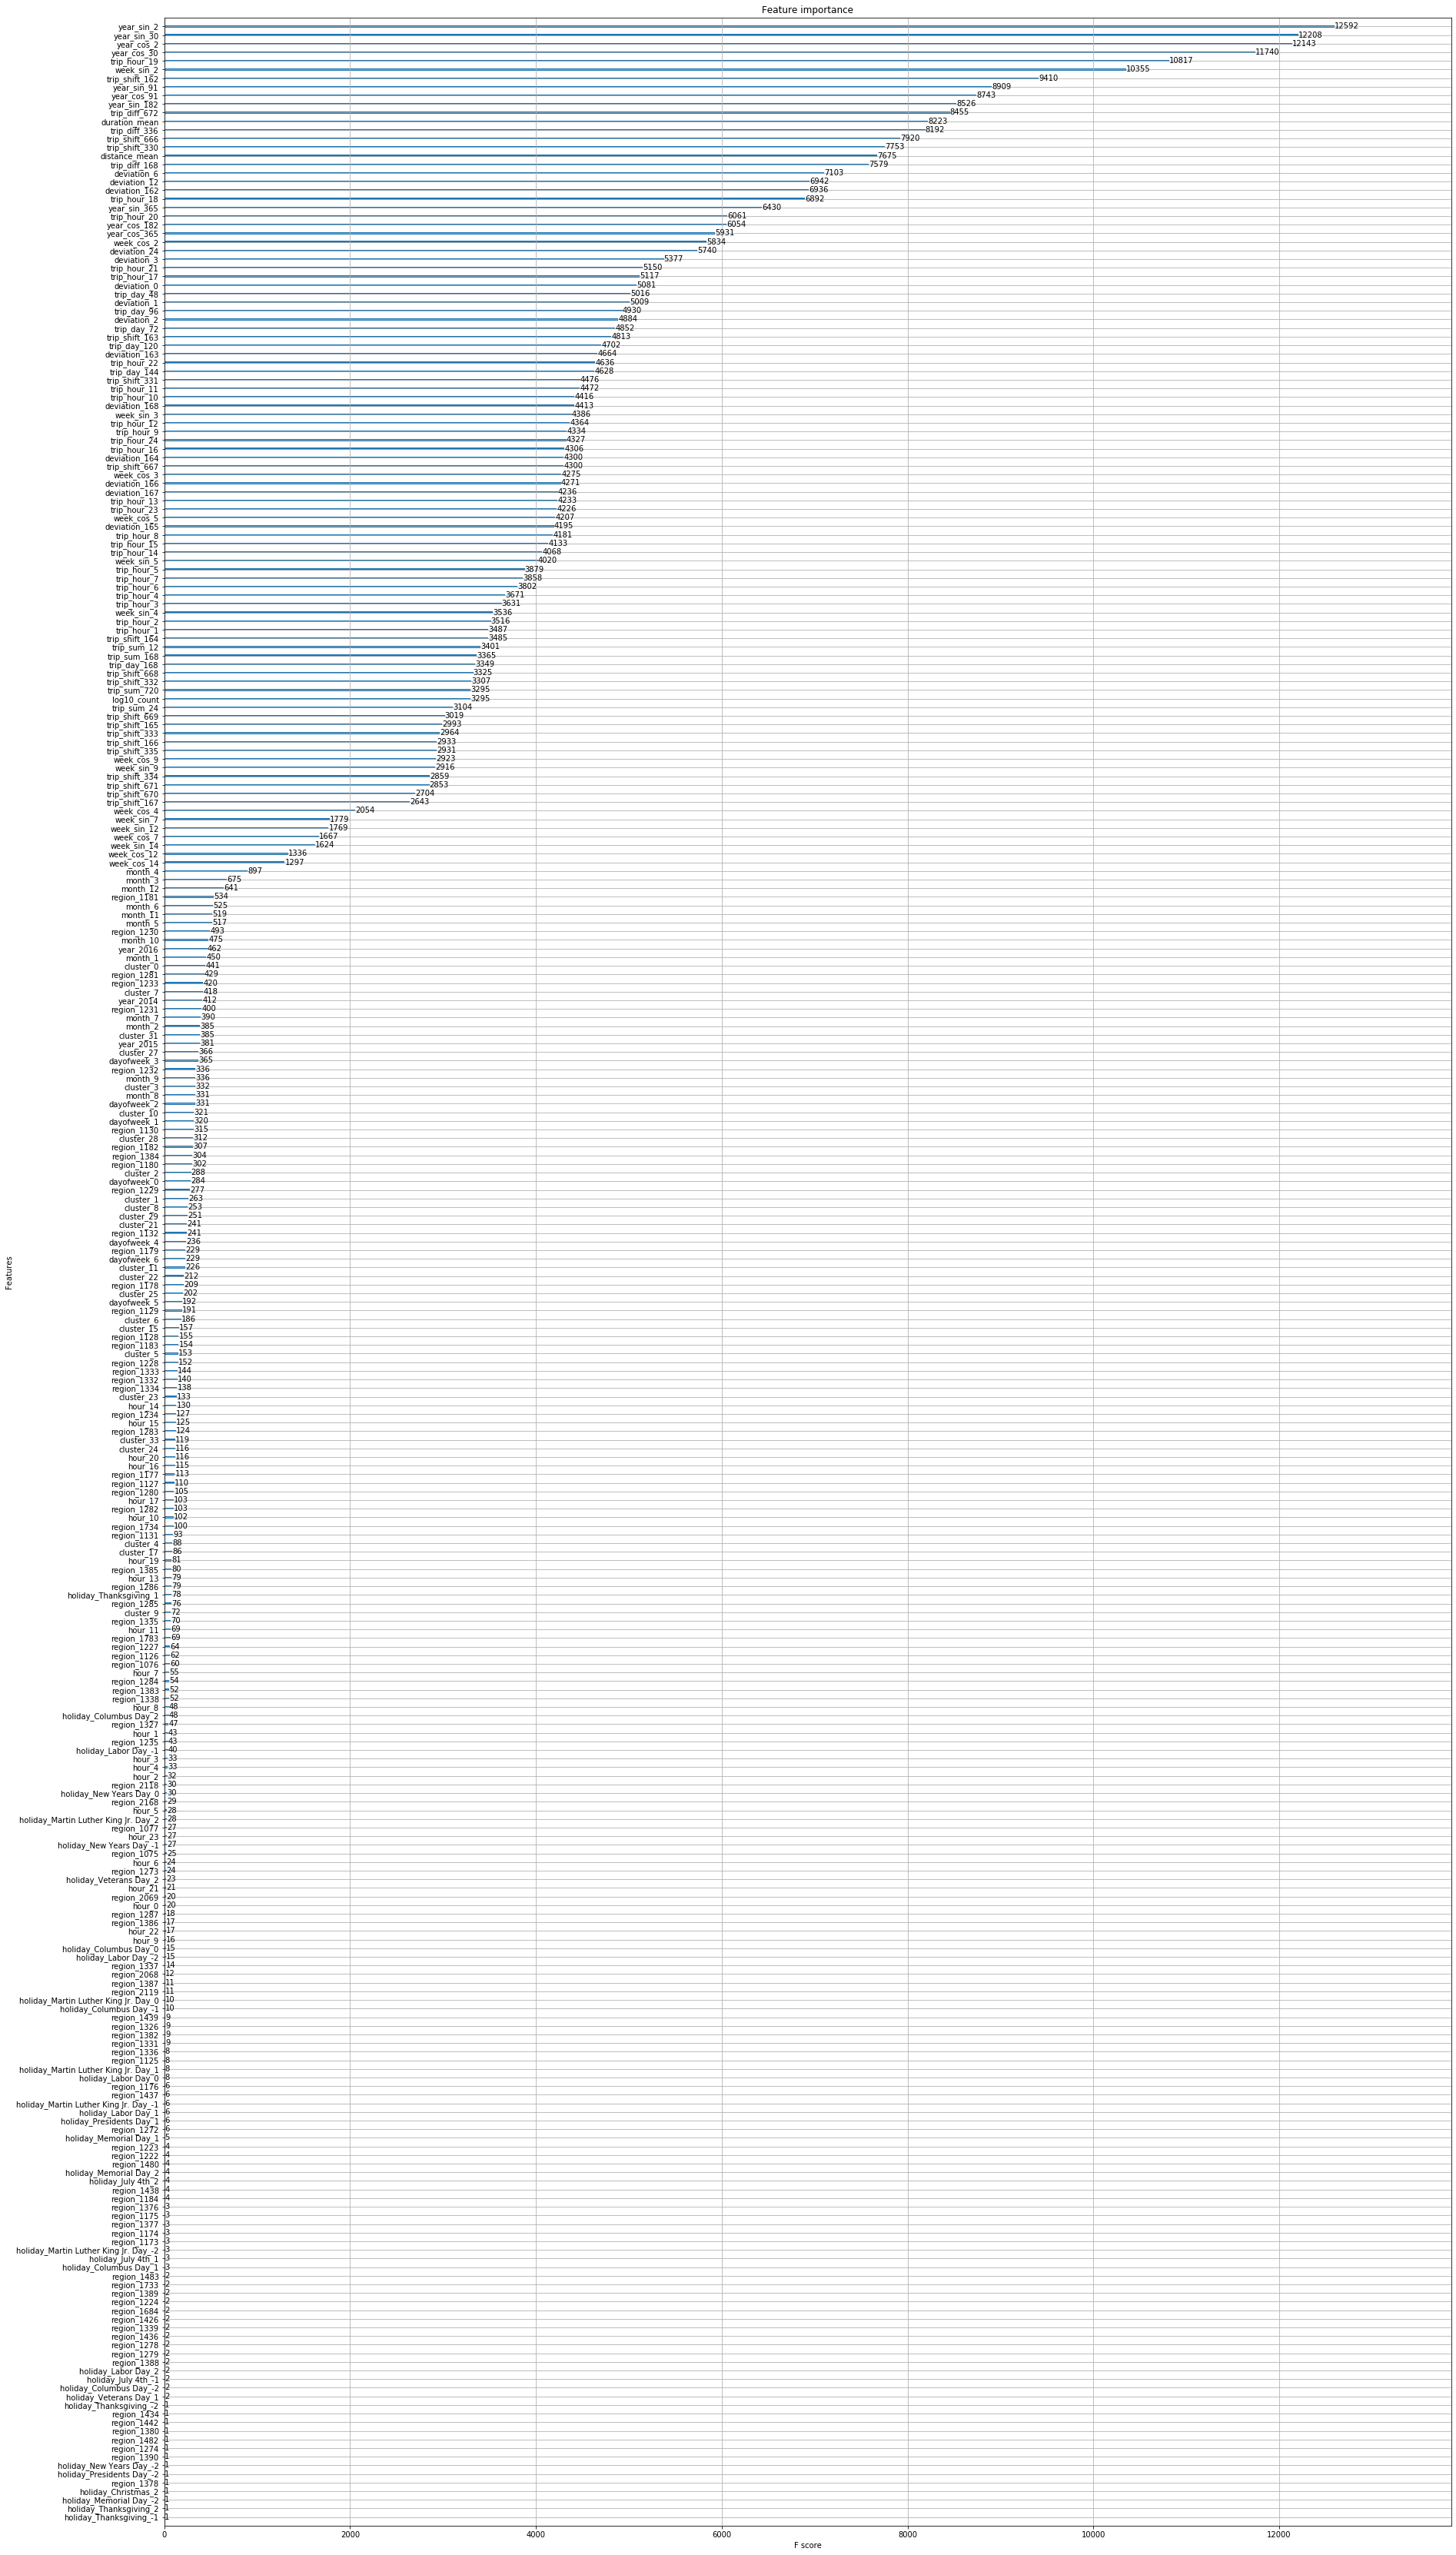

In [37]:
fig, ax = plt.subplots(figsize=(30,60))
xgb.plot_importance(best_estimator, ax=ax)

По этой диаграмме можно увидеть, что наибольший вес у фурье-гармоник, часовых признаков, а так же новых признаков, которые были добавлены - средней длительности и продолжительности поездок, количестве поездок неделю назад и пр.
А вот номер региона и праздники оказывают довольно слабое влияние.

In [38]:
# удалим модель, чтобы очитить память
del best_estimator
gc.collect()

701

#### 3.
Когда вы примете решение остановиться и перестать добавлять признаки, постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза

In [39]:
# XGBRegressor с новыми гиперпараметрами
def calc_predictions_final(trip_data, train_slice, test_slice):    
    return calc_predictions(
        trip_data,
        train_slice,
        test_slice,
        T_range = range(1, 6+1),
        n_jobs=-1,
        tree_method='gpu_hist',
        n_estimators=1200,
        eta=0.1,
        max_depth=9,
        reg_alpha=10.0,
        reg_lambda=100.0,
        gamma=0.3
    )

In [40]:
%%time
predictions, errors = calc_predictions_final(
    trip_data,
    train_slice = slice(None, '2016-04-30 17:00:00'),
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00')
)

build model for T=1
build model for T=2
build model for T=3
build model for T=4
build model for T=5
build model for T=6
Средняя абсолютная ошибка прогноза: 15.590781711459044
Wall time: 1h 4min 23s


По сравнению с предыдущей неделей, ошибка уменьшилась на 6 единиц (было 21.68).

Для более наглядного сравнения, визуализируем график ошибок

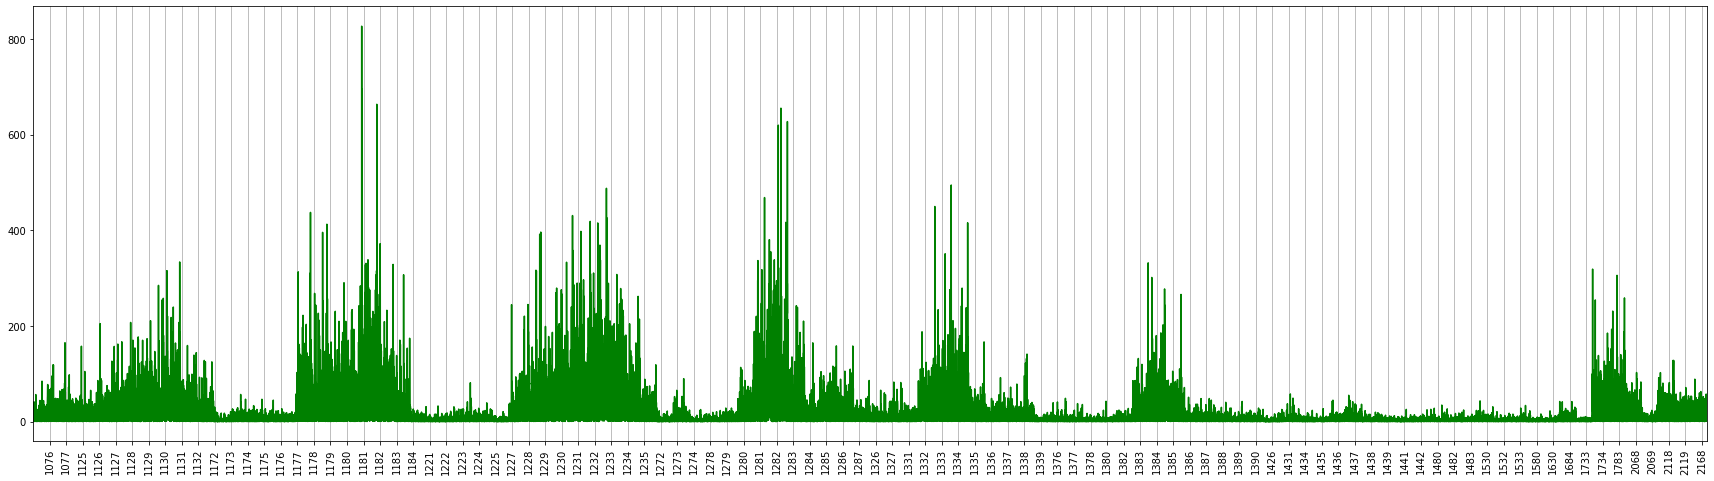

In [41]:
plot_errors(errors)

По графику ошибок видно, что структура осталась такой же, какой была изначально (в некоторых регионах ошибка сильно превышает средний уровень), однако, максимальные значения ошибок уменьшились, сейчас большинство из них не превышает значение 400 (было ~600). Скорее всего, улучшить модель не получится, т.к. эти отклонения, скорее всего, являются случайным шумом.

Построим графики прогноза по зонам с самыми большими отклонениями - 1282 и 1232, а также с минимальными - 1530 и 1441

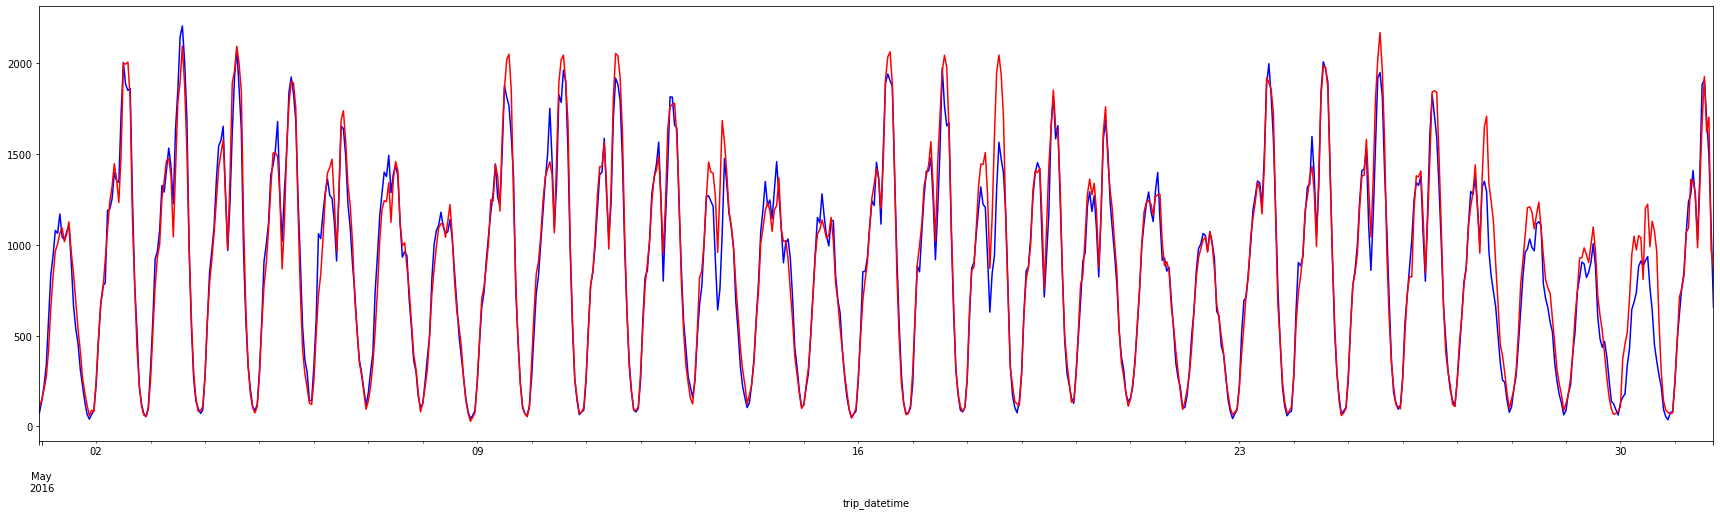

In [42]:
# 1282
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1282
)

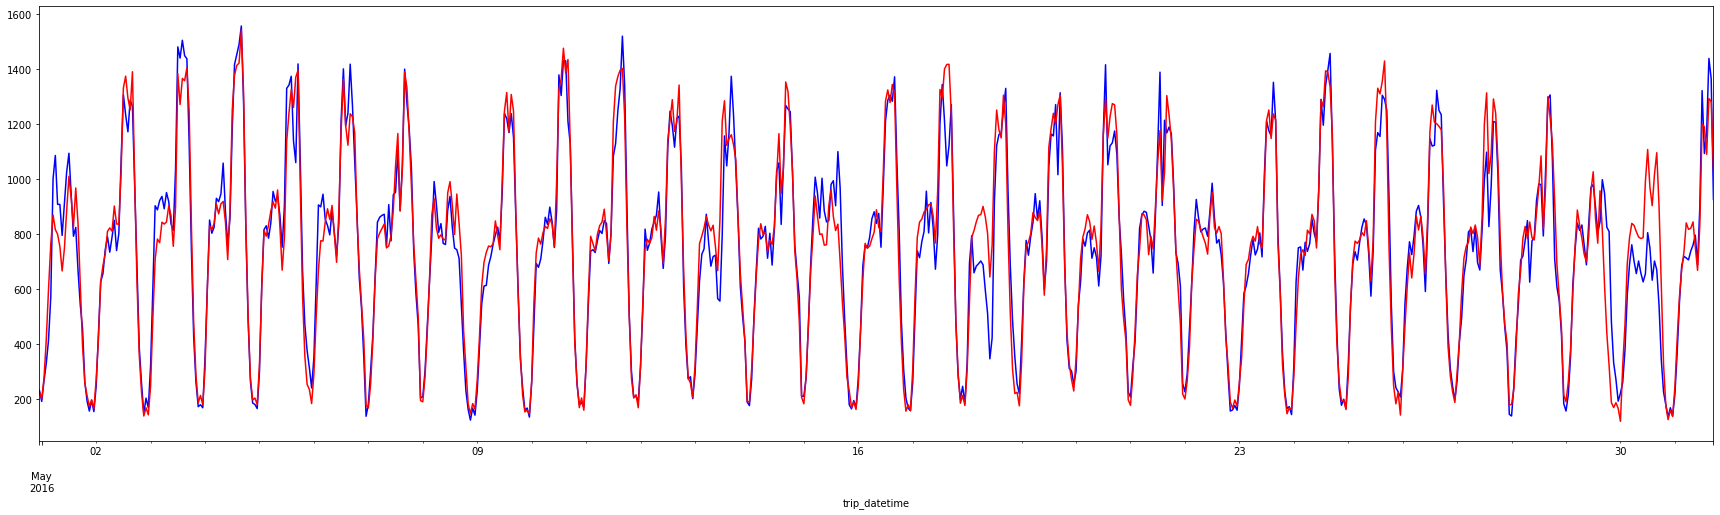

In [43]:
# 1232
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1232
)

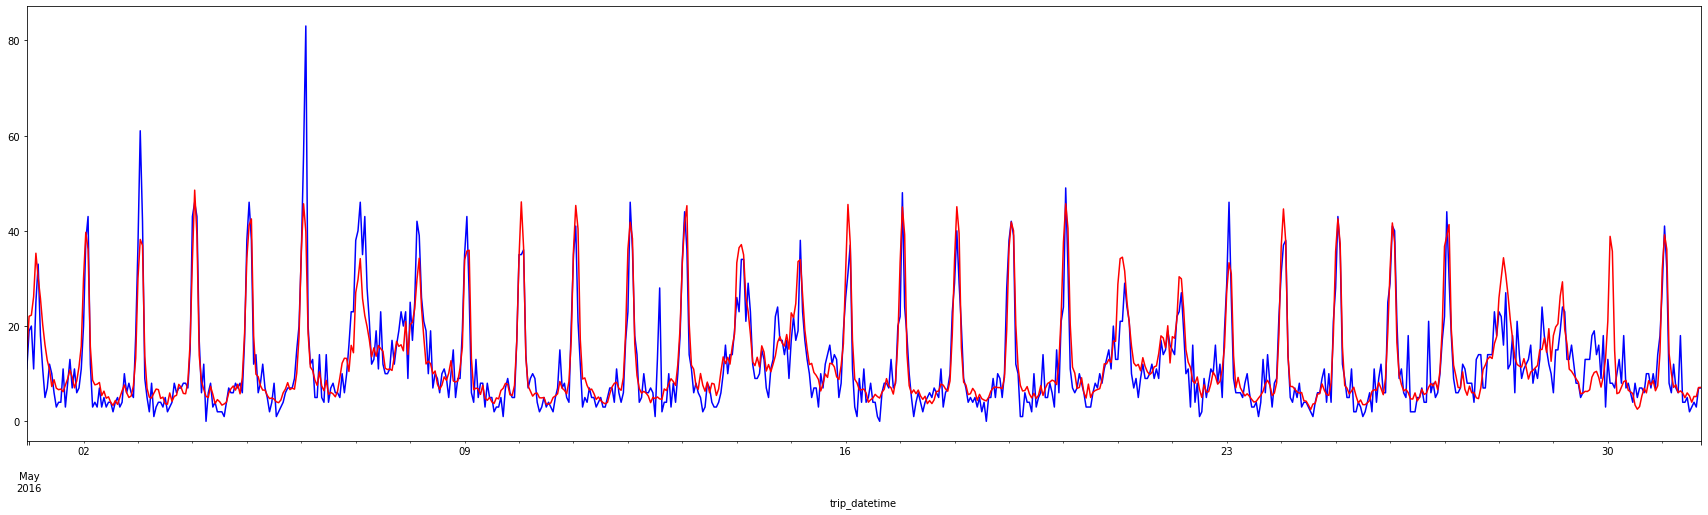

In [106]:
# 1530
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1530
)

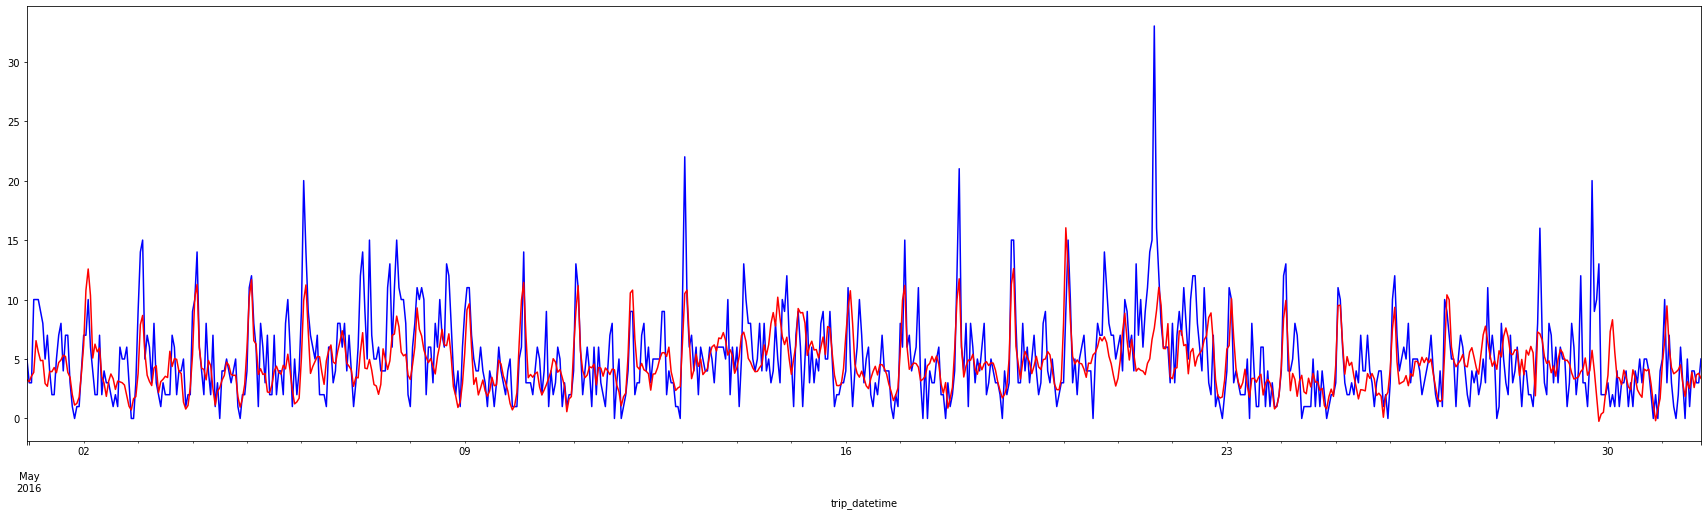

In [107]:
# 1441
plot_predictions(
    trip_data,
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00'),
    predictions=predictions,
    region_id=1441
)

В целом, прогноз довольно близок к реальным данным, а большие значения средней абсолютной ошибки можно объяснить большими значениями количества поездок в пиковые часы (1500-2000). Однако, на регионах с малым количеством поездом (до 10-15) могут наблюдаться довольно плохие значения прогноза. Теоретически можно с ними дополнительно поработать, однако, это существенно не улучшит значение критерия оценки - среднюю абсолютную ошибку

Проверим остатки на стационарность (критерий Дики-Фуллера), несмещенность (критерий Стьюдента), неавтокоррелированность (критерий Льюнга-Бокса) и долю объясненной дисперсии (критерий R2)

In [93]:
def calc_stats(trip_data, predictions, region_id):
    test_slice = slice('2016-04-30 23:00:00','2016-05-31 17:00:00')
    test_idx = np.where(trip_data.data.index.isin(trip_data.data.loc[test_slice].index))[0]
    y_test = trip_data.data.iloc[test_idx].loc[:, ['region_id']]
    for hour in range(1,6+1):
        y_test.loc[:, 'true'] = trip_data.unsplit(hour).y[test_idx]
        y_true = y_test[y_test.region_id==region_id].loc[:, 'true']
        y_pred = predictions[predictions.region_id==region_id].loc[test_slice,'{}'.format(hour)]
        err = (y_true - y_pred).values
        fuller = sm.tsa.adfuller(err)[1]
        student = ttest_1samp(err, 0)[1]
        ljung_box = acorr_ljungbox(err, lags=24, return_df=False)[1][0]
        r2 = r2_score(y_true, y_pred)
        print('T={0}, критерий Дики-Фуллера={1:0.4f}'.format(hour, fuller))
        print('T={0}, критерий Стьюдента={1:0.4f}'.format(hour, student))
        print('T={0}, критерий Льюнга-Бокса={1:0.4f}'.format(hour, ljung_box))
        print('T={0}, критерий R2={1:0.4f}'.format(hour, r2))

In [108]:
# регион 1282, с максимальными значениям ошибок (~600)
calc_stats(trip_data, predictions, region_id=1282)

T=1, критерий Дики-Фуллера=0.0000
T=1, критерий Стьюдента=0.0000
T=1, критерий Льюнга-Бокса=0.0003
T=1, критерий R2=0.9809
T=2, критерий Дики-Фуллера=0.0000
T=2, критерий Стьюдента=0.0000
T=2, критерий Льюнга-Бокса=0.0000
T=2, критерий R2=0.9702
T=3, критерий Дики-Фуллера=0.0000
T=3, критерий Стьюдента=0.0000
T=3, критерий Льюнга-Бокса=0.0000
T=3, критерий R2=0.9657
T=4, критерий Дики-Фуллера=0.0000
T=4, критерий Стьюдента=0.0000
T=4, критерий Льюнга-Бокса=0.0000
T=4, критерий R2=0.9601
T=5, критерий Дики-Фуллера=0.0000
T=5, критерий Стьюдента=0.0000
T=5, критерий Льюнга-Бокса=0.0000
T=5, критерий R2=0.9562
T=6, критерий Дики-Фуллера=0.0000
T=6, критерий Стьюдента=0.0000
T=6, критерий Льюнга-Бокса=0.0000
T=6, критерий R2=0.9507


В регионе 1282 остатки стационарны, несмещенны, неавтокоррелированны, критерий R2 - 95-98%, это можно считать хорошим результатом

In [109]:
# регион 1232, максимальное значение ошибки ~400
calc_stats(trip_data, predictions, region_id=1232)

T=1, критерий Дики-Фуллера=0.0000
T=1, критерий Стьюдента=0.5840
T=1, критерий Льюнга-Бокса=0.0116
T=1, критерий R2=0.9605
T=2, критерий Дики-Фуллера=0.0000
T=2, критерий Стьюдента=0.0457
T=2, критерий Льюнга-Бокса=0.0000
T=2, критерий R2=0.9429
T=3, критерий Дики-Фуллера=0.0000
T=3, критерий Стьюдента=0.0058
T=3, критерий Льюнга-Бокса=0.0000
T=3, критерий R2=0.9341
T=4, критерий Дики-Фуллера=0.0000
T=4, критерий Стьюдента=0.0135
T=4, критерий Льюнга-Бокса=0.0000
T=4, критерий R2=0.9254
T=5, критерий Дики-Фуллера=0.0000
T=5, критерий Стьюдента=0.0470
T=5, критерий Льюнга-Бокса=0.0000
T=5, критерий R2=0.9275
T=6, критерий Дики-Фуллера=0.0000
T=6, критерий Стьюдента=0.0205
T=6, критерий Льюнга-Бокса=0.0000
T=6, критерий R2=0.9227


В регионе 1232 остатки стационарны, несмещенны во всех прогнозах, кроме T+1, неавтокоррелированны, критерий R2 - 92-96%, в целом, результат тоже хороший

In [110]:
# регион 1530, минимальные значения ошибок
calc_stats(trip_data, predictions, region_id=1530)

T=1, критерий Дики-Фуллера=0.0000
T=1, критерий Стьюдента=0.0232
T=1, критерий Льюнга-Бокса=0.1310
T=1, критерий R2=0.7979
T=2, критерий Дики-Фуллера=0.0000
T=2, критерий Стьюдента=0.0026
T=2, критерий Льюнга-Бокса=0.0000
T=2, критерий R2=0.7845
T=3, критерий Дики-Фуллера=0.0000
T=3, критерий Стьюдента=0.0009
T=3, критерий Льюнга-Бокса=0.0000
T=3, критерий R2=0.7761
T=4, критерий Дики-Фуллера=0.0000
T=4, критерий Стьюдента=0.0002
T=4, критерий Льюнга-Бокса=0.0000
T=4, критерий R2=0.7739
T=5, критерий Дики-Фуллера=0.0000
T=5, критерий Стьюдента=0.0005
T=5, критерий Льюнга-Бокса=0.0000
T=5, критерий R2=0.7677
T=6, критерий Дики-Фуллера=0.0000
T=6, критерий Стьюдента=0.0018
T=6, критерий Льюнга-Бокса=0.0000
T=6, критерий R2=0.7603


В регионе 1530 остатки стационарны, несмещенны, неавтокоррелированны, критерий R2 - 76-79%. Визуально по графику, и по критерию R2 результат хуже, чем предыдущих двух регионов, однако, это можно объяснить случайным шумом, судя по критерию Льюнга-Бокса

In [111]:
# регион 1441, с визуально плохим прогнозом и малым количеством поездом (до 20)
calc_stats(trip_data, predictions, region_id=1441)

T=1, критерий Дики-Фуллера=0.0000
T=1, критерий Стьюдента=0.0078
T=1, критерий Льюнга-Бокса=0.0568
T=1, критерий R2=0.4042
T=2, критерий Дики-Фуллера=0.0000
T=2, критерий Стьюдента=0.0084
T=2, критерий Льюнга-Бокса=0.0000
T=2, критерий R2=0.3373
T=3, критерий Дики-Фуллера=0.0000
T=3, критерий Стьюдента=0.0078
T=3, критерий Льюнга-Бокса=0.0000
T=3, критерий R2=0.3368
T=4, критерий Дики-Фуллера=0.0000
T=4, критерий Стьюдента=0.0030
T=4, критерий Льюнга-Бокса=0.0000
T=4, критерий R2=0.3365
T=5, критерий Дики-Фуллера=0.0000
T=5, критерий Стьюдента=0.0000
T=5, критерий Льюнга-Бокса=0.0000
T=5, критерий R2=0.3362
T=6, критерий Дики-Фуллера=0.0000
T=6, критерий Стьюдента=0.0000
T=6, критерий Льюнга-Бокса=0.0000
T=6, критерий R2=0.3216


В регионе 1441 остатки стационарны, несмещенны, неавтокоррелированны, критерий R2 - 32-40%. Судя по всему, распределение количества поездок близко к случайному шуму, это объясняет значения показателей, а также низкое значение R2

#### 4.
Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

In [112]:
%%time
predictions, errors = calc_predictions_final(
    trip_data,
    train_slice = slice(None, '2016-05-31 17:00:00'),
    test_slice = slice('2016-05-31 23:00:00','2016-06-30 17:00:00')
)

build model for T=1
build model for T=2
build model for T=3
build model for T=4
build model for T=5
build model for T=6
Средняя абсолютная ошибка прогноза: 15.241542319297707
Wall time: 1h 4min 23s


In [113]:
# функция формирования прогноза в заданном формате и записи в файл
def write_predictions(df):
    predictions = df.apply(
        lambda row: ''.join([
            '{region}_{:%Y-%m-%d}_{hour}_{ref},{pred}\n'.format(
                row.name,
                hour=row.name.hour,
                region=int(row.region_id),
                ref=T,
                pred=max(row[T], 0)
            ) for T in range(1, 6+1)
        ]),
        axis=1,
    )
    
    with open('june_predict_6.csv', "w") as csv:
        csv.write('id,y\n')
        csv.write(''.join(predictions))

In [114]:
%%time
write_predictions(predictions)

Wall time: 18.9 s


#### 5. 
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

Ссылка: https://www.kaggle.com/submissions/15492217/15492217.raw

Score: 15.23010

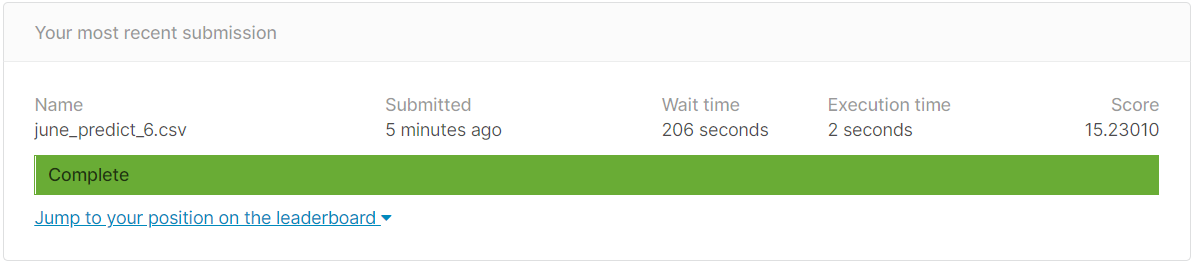

In [115]:
from IPython.display import Image
Image(filename='image.png') 